In [2]:
#TODO: odpalić też na danych miesięcznych
# from utils import DATA_PATH # utils.py

In [3]:
import pandas as pd
import numpy as np
import glob
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA #here the arima.model instead of arima_model
#from statsmodels.tsa.arima_model import ARIMA #usually I used this version
import statsmodels.api as sm
import math
from datetime import datetime

DATA_PATH = './data'
PREPROCESSED_DATA_PATH = DATA_PATH + '/4_preprocessed_data'
PLOTS = './plots'
ARIMA_PLOTS = PLOTS + '/arima_plots'
ARIMA_MODEL_RESULTS = './models_results/ARIMA'

In [4]:
PREPROCESSED_DATA_PATHS = glob.glob(PREPROCESSED_DATA_PATH + "/*.csv")
USE_LOG = True
"""
https://predictivehacks.com/time-series-decomposition/
Our data here are aggregated by days. 
The period we want to analyze is by year so that’s why we set the period to 365.
"""
PERIOD = 365 
P_VALUE_PERCENT = '1%' #['1%', '5%', '10%']
P_VALUE = float(P_VALUE_PERCENT.strip('%')) / 100.0
"""
'c' : constant only
'ct' : constant and trend.
'ctt' : constant, and linear and quadratic trend
'n' : no constant, no trend
"""
REGRESSION_TYPE_FOR_DF_TEST = 'c' #['c', 'ct', 'ctt', 'n']
#najczęściej występuje wersja ze stałą, czyli 'c'
AUTOLAG_FOR_DF_TEST = 'AIC' #['AIC', 'BIC'], może być zawsze AIC

LJUNGBOX_BOXPIERCE_LAGS = 24 #dla szeregu niesezonowego najczęściej ilosc lagow=24

PERIODS_TO_FORECAST = [7, 14, 28]

#p and q ranges
P_RANGE = range(0, 2) #range(0, 10)
Q_RANGE = range(0, 2) #range(0, 10)

#columns to create table with MAE for experiments
COLUMN_NAMES = ['Company', 'ARIMA', 'p', 'd', 'q', 'fc_period', 'MAE']

In [5]:
def decompose_time_series(df, company, period):
    """
    sm.tsa.seasonal_decompose returns a DecomposeResult. 
    This has attributes observed, trend, seasonal and resid, which are pandas series. 
    You may plot each of them using the pandas plot functionality.
    """
    df.set_index('timestamp', inplace=True)
    df.index=pd.to_datetime(df.index)
    result = seasonal_decompose(df['avg_price'], period=period)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14,22), dpi=65)
    ax1.plot(result.observed, color='blue', linewidth=1)
    ax1.set_title('{0} original time series'.format(company))
    ax2.plot(result.trend, color='red', linewidth=1)
    ax2.set_title('Trend')
    ax3.plot(result.seasonal, color='red', linewidth=1)
    ax3.set_title('Seasonality')
    ax4.plot(result.resid, color='red', linewidth=1)
    ax4.set_title('Residuals')
    plt.xlabel('Date')
    plt.savefig(ARIMA_PLOTS + '/{0}_decomposition.png'.format(company));
    plt.show()
    plt.close(fig)

In [6]:
def visualize_after_log(df):
    fig = plt.figure(figsize=(14,7), dpi=100)
    plt.plot(df['timestamp'], df['avg_price'], color='purple', linewidth=2, linestyle='solid')
    plt.title("{0} after logarithm".format(company))
    plt.xlabel('Date')
    plt.ylabel('Daily average log price values')
    plt.legend(['{0}'.format(company)]) 
    plt.savefig(ARIMA_PLOTS + '/{0}_after_log.png'.format(company));
    plt.show()
    plt.close(fig)

In [7]:
def perform_df_test(timeseries, reg, autol, pval):
    """
    I choose AIC as autolag (more often used than BIC). 
    I choose regression type (reg) as 'c' : constant only (default). 
    """
    dftest = adfuller(timeseries, regression = reg, autolag = autol)
    #p_value = dftest[1]
    test_statistic = dftest[0]
    critical_value = dftest[4][pval]
    
    return test_statistic, critical_value

In [8]:
def perform_first_difference(df, number_of_first_diff):
    if number_of_first_diff == 1:
        df['diff_price'] = df.avg_price.diff()
        df.drop('avg_price', axis=1, inplace=True)
    else:
        df.diff_price = df.diff_price.diff()
    df = df.iloc[1: , :]
    df = df.reset_index(drop=True)
    
    fig = plt.figure(figsize=(14,7), dpi=100)
    plt.plot(df['timestamp'], df['diff_price'], color='green', linewidth=1, linestyle='solid')
    plt.title("{0} after {1} first difference".format(company, number_of_first_diff))
    plt.xlabel('Date')
    plt.ylabel('Daily average price values after log and first diff')
    plt.legend(['{0}'.format(company)]) 
    plt.savefig(ARIMA_PLOTS + '/{0}_after_{1}_first_difference.png'.format(company, number_of_first_diff));
    plt.show()
    plt.close(fig)
    
    return df

In [9]:
def perform_ljungbox_boxpierce(df_price, p, d, q, lags):
    """
    Performs Ljung-Box and Box-Pierce tests. Check the residuals autocorrelations. 
    https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html
    Remember, that p, d, q values HAVE TO BE INTEGERS!!
    """
    res = sm.tsa.ARIMA( df_price, (p, d, q) ).fit(disp=-1)
    lb_bp_results = sm.stats.acorr_ljungbox(res.resid, lags=[lags], return_df=True, boxpierce = True)
    lb_p_value = lb_bp_results['lb_pvalue'].values[0]
    bp_p_value = lb_bp_results['bp_pvalue'].values[0]
    residuals = res.resid
    
    return lb_p_value, bp_p_value, residuals

In [10]:
def create_acf_pacf_charts(series, lags, datatype):
    """
    Remember to ommit first tab ("wypustka"), because it's the correlation of the variable with itself. 
    It can be ommited by using parameter zero=False. 
    Documentation about plot_acf: https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
    zero: bool, optional
    Flag indicating whether to include the 0-lag autocorrelation. Default is True.
    """
    #SET TEMPORARY PLOT STYLE
    plt.style.use('classic')
    plt.rcParams['figure.facecolor'] = 'white'
    #ACF
    fig = plt.figure(figsize=(12,9), dpi=90)
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series, lags=LJUNGBOX_BOXPIERCE_LAGS, zero=False, ax=ax1) #residuals
    plt.ylabel('Value')
    #PACF
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=LJUNGBOX_BOXPIERCE_LAGS, zero=False, method="ywm", ax=ax2) #residuals
    plt.ylabel('Value')
    plt.xlabel('Number of tabs')
    plt.savefig(ARIMA_PLOTS + '/{0}_{1}_plot_ACF_and_PACF.png'.format(company, datatype)); #, bbox_inches=0
    plt.show()
    plt.close(fig)
    
    #BACK TO DEFINED STYLE
    plt.style.use('fivethirtyeight')
    plt.style.use('seaborn-bright')

In [11]:
def create_prediction_plot(df, train, test, fc_series, lower_series, upper_series, period, train_timestamp, test_timestamp):
    #prepare xticks for plot
    #list_x_ticks = []
    #list_timestamps_x_ticks = []
    #final_year = df.timestamp[len(df)-1].year
    #for xtick in range(0, len(df) + round(len(df)/7), round(len(df)/7)):
    #    list_x_ticks.append(xtick)
    #    if xtick > len(df):
    #        list_timestamps_x_ticks.append(final_year + 2)
    #    else:
    #        list_timestamps_x_ticks.append(df.timestamp[xtick].year)

    #prepare yticks for plot
    list_y_ticks = []
    display(df.avg_price.min(), df.avg_price.max())
    min_val = df.avg_price.min()
    max_val = df.avg_price.max()
    step = (max_val - min_val) / 7
    print("step:", step)
    print('\n')
    for ytick in np.arange(min_val, max_val+step, step):
        print(ytick)
        list_y_ticks.append(round(ytick, 2))
    display(list_y_ticks)

    #prepare y_exp_ticks for plot
    list_exp_y_ticks = []
    display(df.avg_price.min(), df.avg_price.max())
    display(np.exp(df.avg_price.min()), np.exp(df.avg_price.max()))
    min_val = np.exp(df.avg_price.min())
    max_val = np.exp(df.avg_price.max())
    step = (max_val - min_val) / 7
    print("step:", step)
    print('\n')
    for ytick in np.arange(min_val, max_val+step, step):
        print(ytick)
        list_exp_y_ticks.append(round(ytick, 2))
    display(list_exp_y_ticks)

    # Plot
    #SET TEMPORARY PLOT STYLE
    plt.style.use('classic')
    plt.rcParams['figure.facecolor'] = 'white'

    fig = plt.figure(figsize=(12,7), dpi=90)

    plt.plot(train_timestamp, train, label='training', linewidth=1) #train.index
    plt.plot(test_timestamp, test, label='actual', linewidth=1) #test.index
    plt.plot(test_timestamp, fc_series, label='forecast', linewidth=1) #fc_series.index

    plt.fill_between(test_timestamp, lower_series, upper_series, color='k', alpha=.15) #lower_series.index, 

    plt.title(f'Forecast vs Actuals for forecast period = {period}')
    plt.legend(loc='upper left', fontsize=8)
    plt.xlabel('Time [years]')
    plt.ylabel('Real value [\$]')
    #plt.xticks(list_x_ticks, list_timestamps_x_ticks, rotation = 45)
    plt.yticks(list_y_ticks, list_exp_y_ticks, color="red")
    plt.savefig(ARIMA_PLOTS + '/{0}_ARIMA_prediction_plot.png'.format(company))
    plt.show()

    #now zoom in
    plt.close(fig)
    #################################################

In [12]:
def create_zoomed_prediction_plot(df, test, fc_series, lower_series, upper_series, period, test_timestamp):
    #prepare yticks
    #minimum_value = lower_series.values.min()
    #maximum_value = upper_series.values.max()
    minimum_value = min(lower_series)
    maximum_value = max(upper_series)
    print("min value",minimum_value, "max value", maximum_value)

    #prepare yticks for plot
    list_y_ticks = []
    #display(minimum_value, maximum_value)
    min_val = round(minimum_value, 2)
    max_val = round(maximum_value, 2)
    print("min value",min_val, "max value", max_val)
    step = round((max_val - min_val) / 7, 2)
    print("step:", step)
    print('\n')
    for ytick in np.arange(min_val, max_val+step, step):
        #print(ytick)
        list_y_ticks.append(round(ytick, 2))
    display("final y list", list_y_ticks)

    #prepare y_exp_ticks for plot
    list_exp_y_ticks = []
    print("min value",minimum_value, "max value", maximum_value)
    min_val = round(np.exp(minimum_value), 2)
    max_val = round(np.exp(maximum_value), 2)
    print("min exp value",min_val, "max exp value", max_val)
    step = round((max_val - min_val) / 6, 2)
    print("step:", step)
    print('\n')
    for ytick in np.arange(min_val, max_val, step):
        #print(ytick)
        list_exp_y_ticks.append(round(ytick, 2))
    display("final y exp list", list_exp_y_ticks)
    
    #PLOT
    fig = plt.figure(figsize=(12,7), dpi=90)
    ax3 = plt.subplot(111)
    plt.plot(test_timestamp, test, label='actual', linewidth=2) #test.index
    plt.plot(test_timestamp, fc_series, label='forecast', linewidth=2)
    plt.fill_between(test_timestamp, lower_series, upper_series, color='k', alpha=.15)

    #ax3.margins(x=-0.49, y=-0.25)
    #ax3.xaxis.zoom(4)
    plt.title(f'Forecast vs Actuals for forecast period = {period}')
    plt.legend(loc='upper left', fontsize=8)
    plt.xticks(rotation=45)
    #plt.xticks(list_x_ticks, list_timestamps_x_ticks, rotation = 45)
    plt.yticks(list_y_ticks, list_exp_y_ticks, color="red")
    plt.ylabel('Real value [\$]')
    plt.xlabel('Date')
    #plt.xlim(2019, 2021)
    plt.tight_layout() #in order not to cut bottom part of plot in saved one
    plt.savefig(ARIMA_PLOTS + '/{0}_ARIMA_zoomed_prediction_plot.png'.format(company))
    plt.show()
    plt.close(fig)

ACN


,timestamp,avg_price
0,2008-01-02,36.097190
1,2008-01-03,35.620970
2,2008-01-04,34.970941
3,2008-01-05,34.680679
4,2008-01-06,34.390417
...,...,...
5009,2021-10-15,340.964570
5010,2021-10-16,341.661594
5011,2021-10-17,342.358618
5012,2021-10-18,343.055643


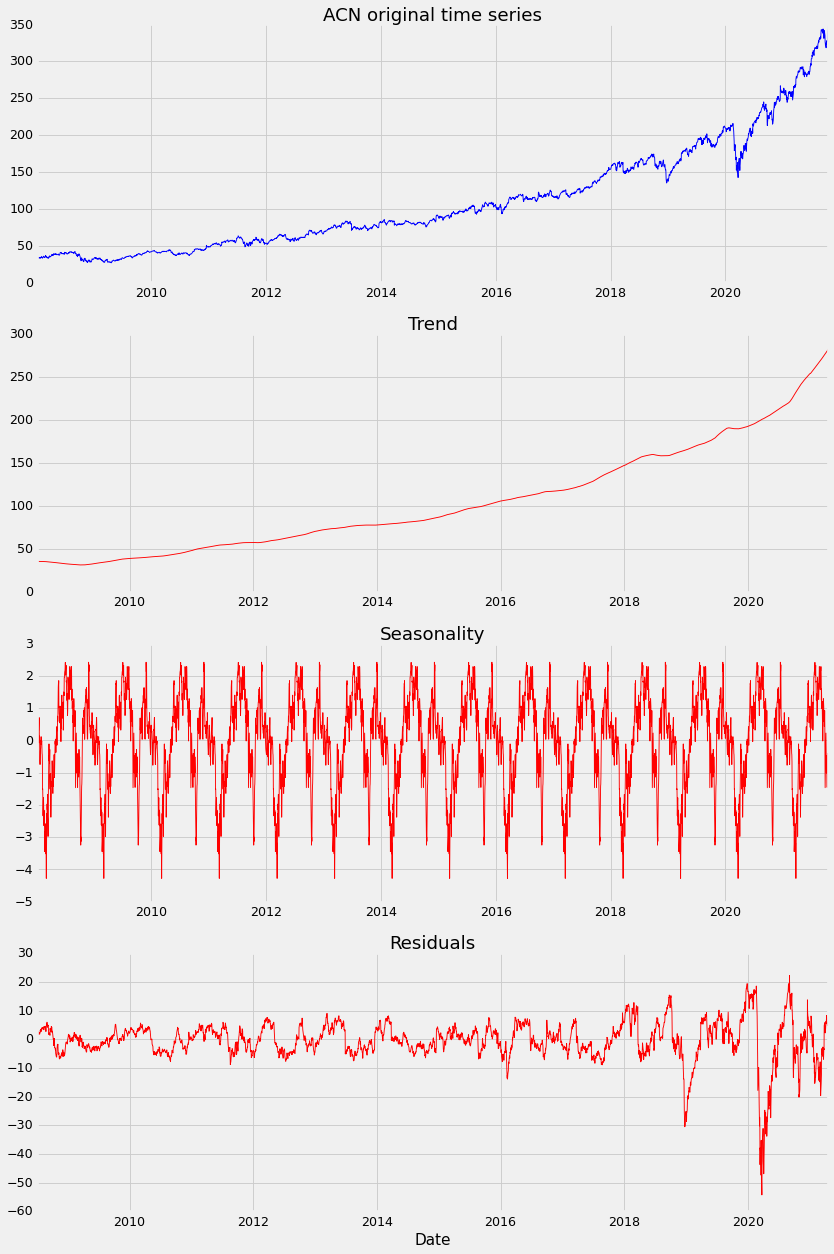

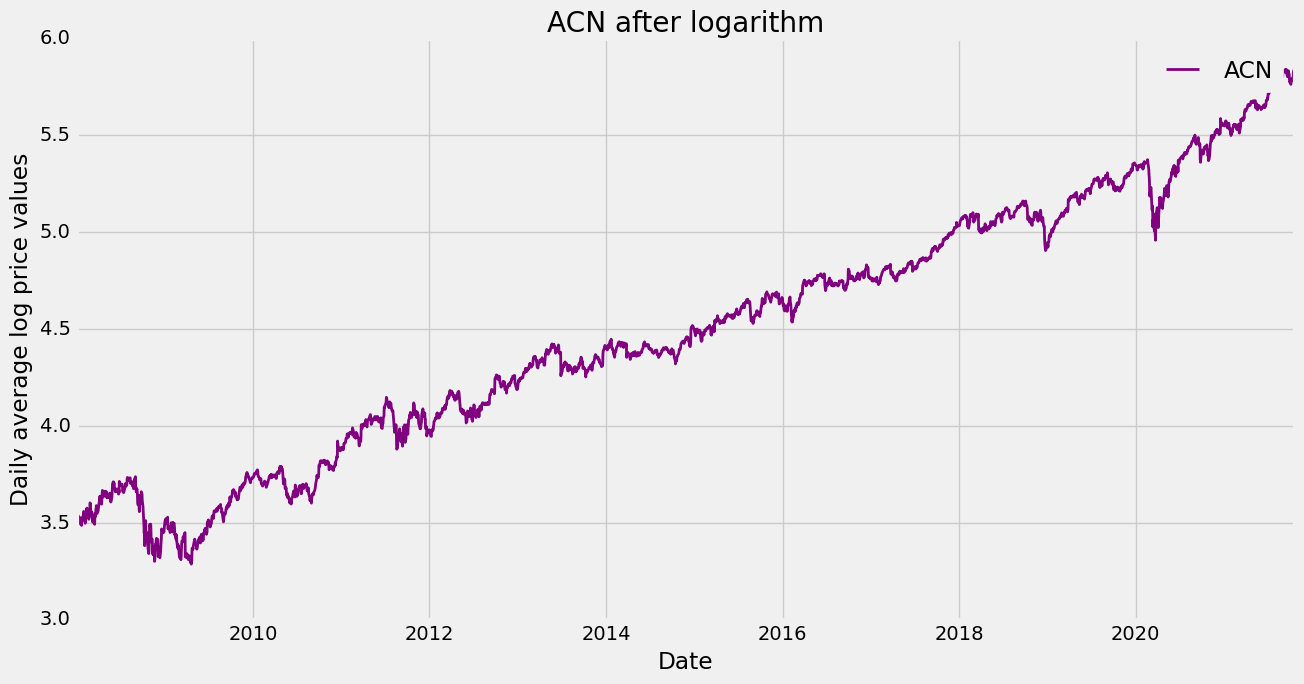

,timestamp,avg_price
0,2008-01-02,3.586215
1,2008-01-03,3.572934
2,2008-01-04,3.554517
3,2008-01-05,3.546183
4,2008-01-06,3.537778
...,...,...
5009,2021-10-15,5.831779
5010,2021-10-16,5.833821
5011,2021-10-17,5.835859
5012,2021-10-18,5.837893


0.27707836397339175 -3.4316572241792462


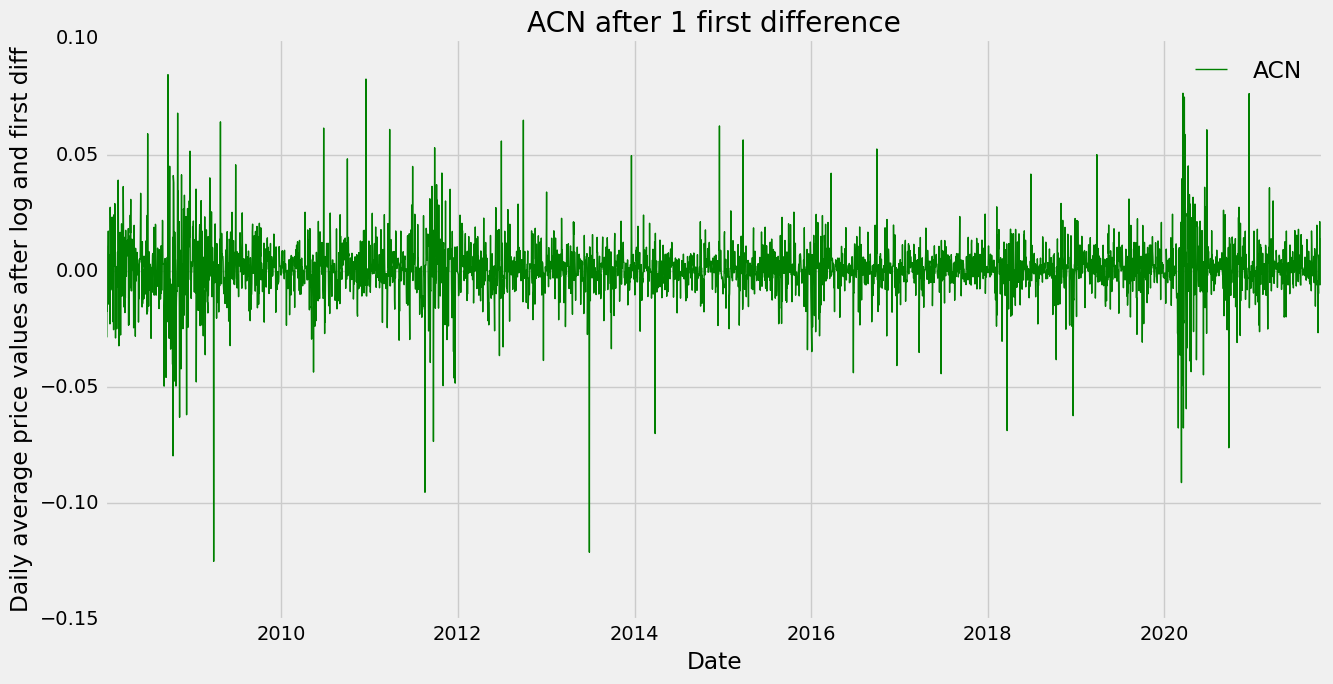

Number of first diff = 1
-26.755893250629892 -3.4316572241792462
Number of performed first diff = 1


'Original dataframe'

,timestamp,avg_price
0,2008-01-02,3.586215
1,2008-01-03,3.572934
2,2008-01-04,3.554517
3,2008-01-05,3.546183
4,2008-01-06,3.537778
...,...,...
5009,2021-10-15,5.831779
5010,2021-10-16,5.833821
5011,2021-10-17,5.835859
5012,2021-10-18,5.837893


'First differenced dataframe'

,timestamp,diff_price
0,2008-01-03,-0.013281
1,2008-01-04,-0.018417
2,2008-01-05,-0.008335
3,2008-01-06,-0.008405
4,2008-01-07,-0.008476
...,...,...
5008,2021-10-15,0.010468
5009,2021-10-16,0.002042
5010,2021-10-17,0.002038
5011,2021-10-18,0.002034


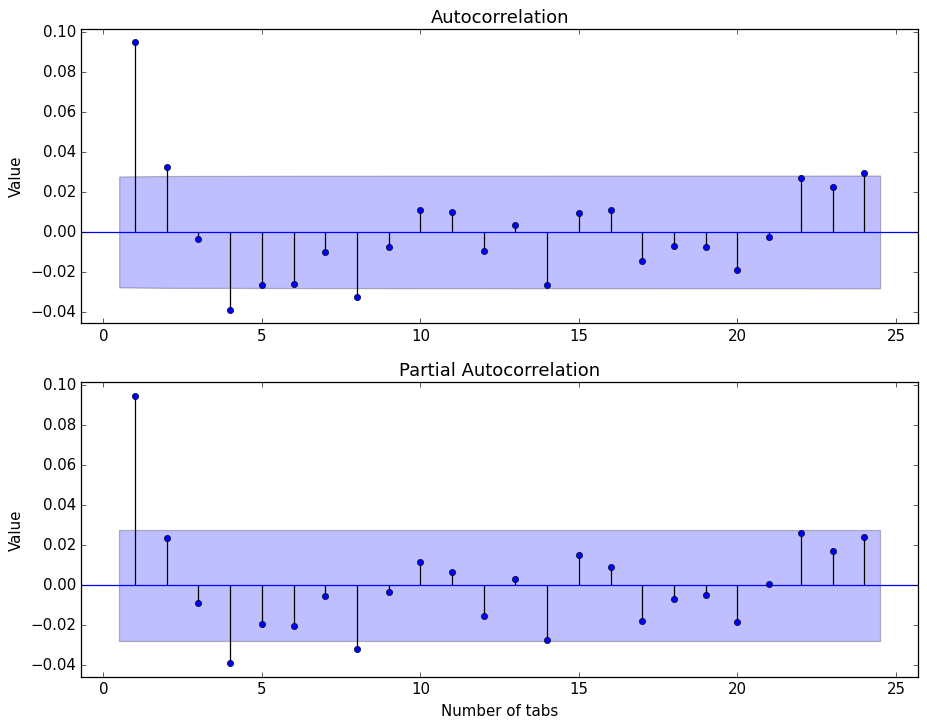

[-27855.468132599308, -30808.882178581065, -29078.302230927362, -30852.00659131224]
[-27848.948741824348, -30795.84379619291, -29065.263449377442, -30832.449017730003]


,ARIMA,p,d,q,AIC,BIC
0,"ARIMA(0,1,0)",0,1,0,-27855.468133,-27848.948742
1,"ARIMA(0,1,1)",0,1,1,-30808.882179,-30795.843796
2,"ARIMA(1,1,0)",1,1,0,-29078.302231,-29065.263449
3,"ARIMA(1,1,1)",1,1,1,-30852.006591,-30832.449018


Best ARIMA according to AIC criterium:
ARIMA    ARIMA(1,1,1)
p                   1
d                   1
q                   1
AIC            -30852
BIC          -30832.4
Name: 3, dtype: object

Best ARIMA according to BIC criterium:
ARIMA    ARIMA(1,1,1)
p                   1
d                   1
q                   1
AIC            -30852
BIC          -30832.4
Name: 3, dtype: object


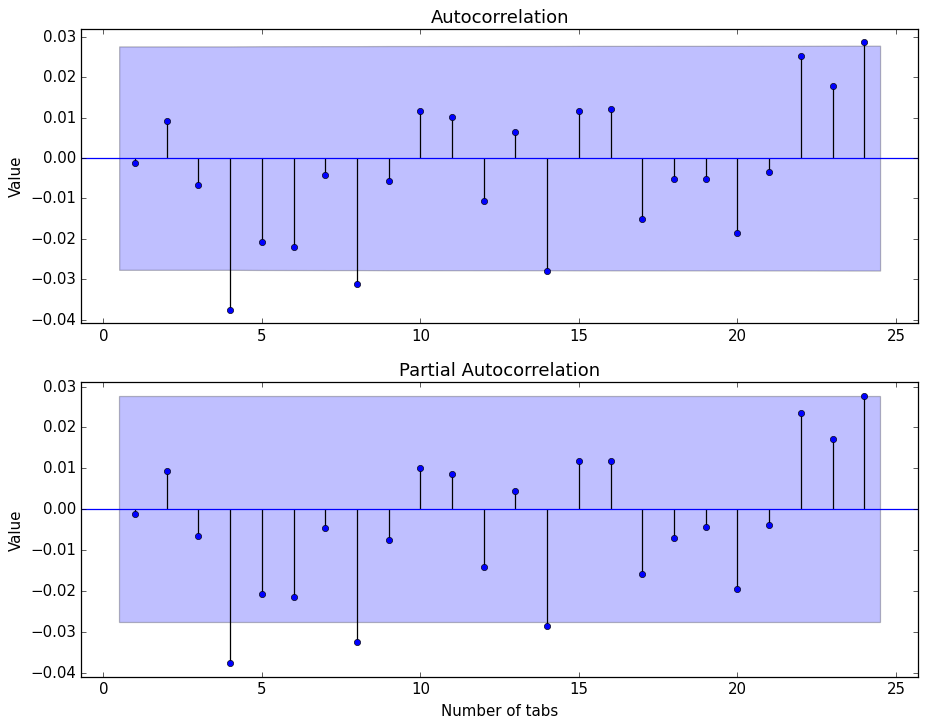

C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Forecast results for per=0
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.794015  0.011114       5.772232       5.815797
predicted=5.794015, expected=5.796638
Forecast results for per=1
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.796983  0.011113       5.775203       5.818764
predicted=5.796983, expected=5.821311
Forecast results for per=2
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.823687  0.011117       5.801898       5.845475
predicted=5.823687, expected=5.831779
Forecast results for per=3
y     mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.83329  0.011116       5.811502       5.855078
predicted=5.833290, expected=5.833821
Forecast results for per=4
y     mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.83435  0.011115       5.812565       5.856136
predicted=5.834350, expected=5.835859
Forecast results for per=5
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.836168  0.011114       5.814385       5.857952
predicted=5.836168, expected

C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Forecast results for per=6
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.838152  0.011113       5.816371       5.859934
predicted=5.838152, expected=5.856061


,prediction,se,lower_series,upper_series
0,5.794015,0.011114,5.772232,5.815797
1,5.796983,0.011113,5.775203,5.818764
2,5.823687,0.011117,5.801898,5.845475
3,5.833290,0.011116,5.811502,5.855078
4,5.834350,0.011115,5.812565,5.856136
5,5.836168,0.011114,5.814385,5.857952
6,5.838152,0.011113,5.816371,5.859934


3.285925749214768

5.856061292856436

step: 0.36716222052023834


3.285925749214768
3.6530879697350067
4.020250190255245
4.387412410775484
4.754574631295722
5.12173685181596
5.488899072336199
5.856061292856438


[3.29, 3.65, 4.02, 4.39, 4.75, 5.12, 5.49, 5.86]

3.285925749214768

5.856061292856436

26.733721584630885

349.34546122466844

step: 46.08739137714822


26.733721584630885
72.82111296177911
118.90850433892733
164.99589571607555
211.08328709322376
257.17067847037197
303.25806984752023
349.34546122466844


[26.73, 72.82, 118.91, 165.0, 211.08, 257.17, 303.26, 349.35]

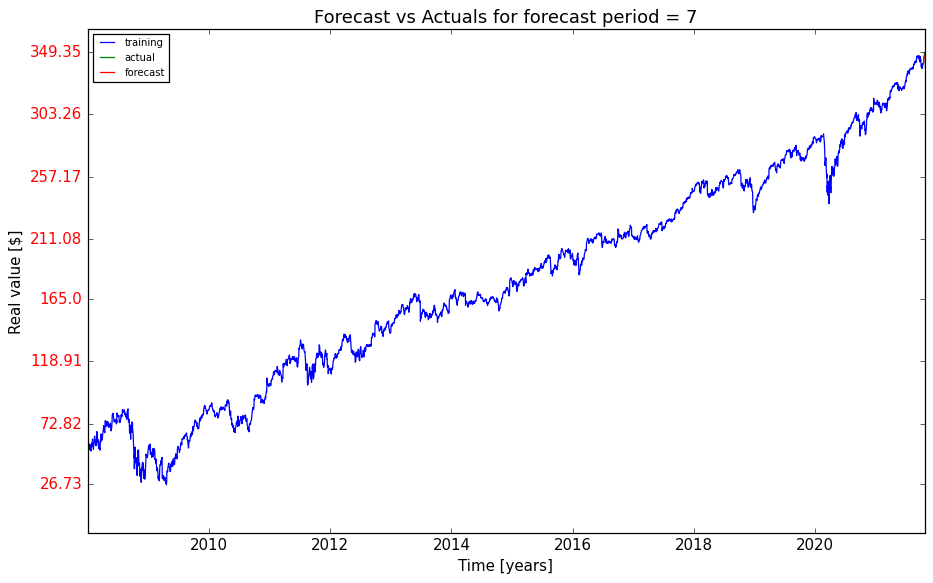

min value 5.772232291627717 max value 5.859933511064135
min value 5.77 max value 5.86
step: 0.01




'final y list'

[5.77, 5.78, 5.79, 5.8, 5.81, 5.82, 5.83, 5.84, 5.85, 5.86, 5.87]

min value 5.772232291627717 max value 5.859933511064135
min exp value 321.25 max exp value 350.7
step: 4.91




'final y exp list'

[321.25, 326.16, 331.07, 335.98, 340.89, 345.8]

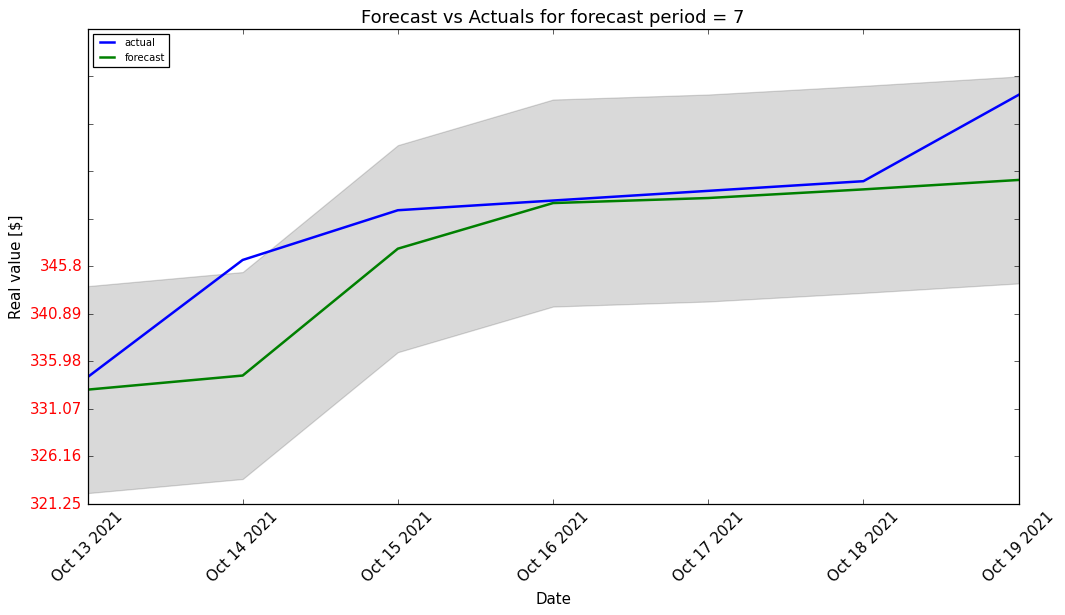

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(1,1,1)  1  1  1         7  0.008102
Forecast results for per=0
y    mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.7864  0.011119       5.764608       5.808193
predicted=5.786400, expected=5.778541


C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Forecast results for per=1
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.778383  0.011118       5.756592       5.800174
predicted=5.778383, expected=5.792252
Forecast results for per=2
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.793496  0.011119       5.771704       5.815289
predicted=5.793496, expected=5.786836
Forecast results for per=3
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.786609  0.011118       5.764818         5.8084
predicted=5.786609, expected=5.788095


C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Forecast results for per=4
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.788161  0.011117       5.766372        5.80995
predicted=5.788161, expected=5.789351
Forecast results for per=5
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.789483  0.011116       5.767697        5.81127
predicted=5.789483, expected=5.790607
Forecast results for per=6
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.790753  0.011115       5.768968       5.812538
predicted=5.790753, expected=5.793695


C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Forecast results for per=7
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.794015  0.011114       5.772232       5.815797
predicted=5.794015, expected=5.796638
Forecast results for per=8
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.796983  0.011113       5.775203       5.818764
predicted=5.796983, expected=5.821311
Forecast results for per=9
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.823687  0.011117       5.801898       5.845475
predicted=5.823687, expected=5.831779
Forecast results for per=10
y     mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.83329  0.011116       5.811502       5.855078
predicted=5.833290, expected=5.833821
Forecast results for per=11
y     mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.83435  0.011115       5.812565       5.856136
predicted=5.834350, expected=5.835859
Forecast results for per=12
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.836168  0.011114       5.814385       5.857952
predicted=5.836168, expec

C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,prediction,se,lower_series,upper_series
0,5.786400,0.011119,5.764608,5.808193
1,5.778383,0.011118,5.756592,5.800174
2,5.793496,0.011119,5.771704,5.815289
3,5.786609,0.011118,5.764818,5.808400
4,5.788161,0.011117,5.766372,5.809950
5,5.789483,0.011116,5.767697,5.811270
6,5.790753,0.011115,5.768968,5.812538
7,5.794015,0.011114,5.772232,5.815797
8,5.796983,0.011113,5.775203,5.818764
9,5.823687,0.011117,5.801898,5.845475


3.285925749214768

5.856061292856436

step: 0.36716222052023834


3.285925749214768
3.6530879697350067
4.020250190255245
4.387412410775484
4.754574631295722
5.12173685181596
5.488899072336199
5.856061292856438


[3.29, 3.65, 4.02, 4.39, 4.75, 5.12, 5.49, 5.86]

3.285925749214768

5.856061292856436

26.733721584630885

349.34546122466844

step: 46.08739137714822


26.733721584630885
72.82111296177911
118.90850433892733
164.99589571607555
211.08328709322376
257.17067847037197
303.25806984752023
349.34546122466844


[26.73, 72.82, 118.91, 165.0, 211.08, 257.17, 303.26, 349.35]

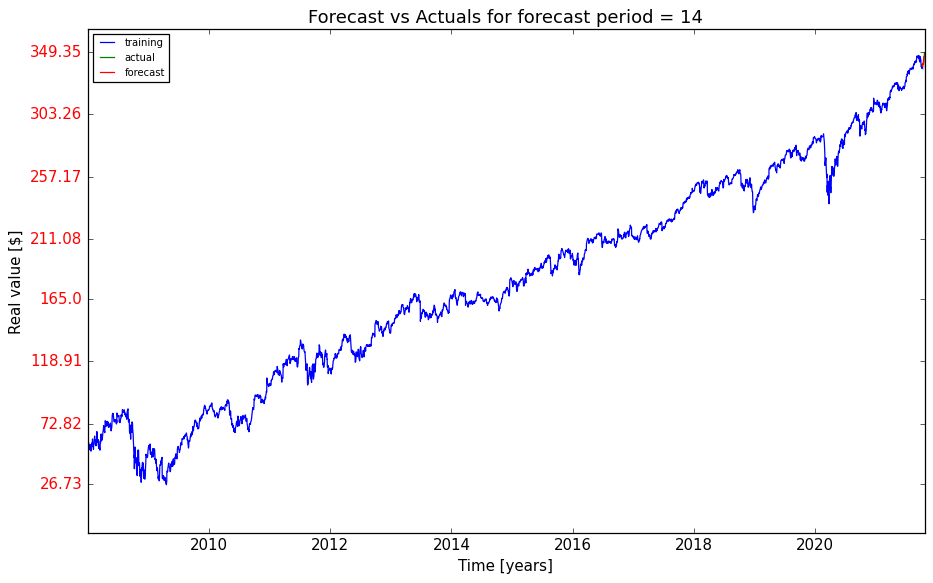

min value 5.756591819462488 max value 5.859933511064135
min value 5.76 max value 5.86
step: 0.01




'final y list'

[5.76, 5.77, 5.78, 5.79, 5.8, 5.81, 5.82, 5.83, 5.84, 5.85, 5.86, 5.87]

min value 5.756591819462488 max value 5.859933511064135
min exp value 316.27 max exp value 350.7
step: 5.74




'final y exp list'

[316.27, 322.01, 327.75, 333.49, 339.23, 344.97]

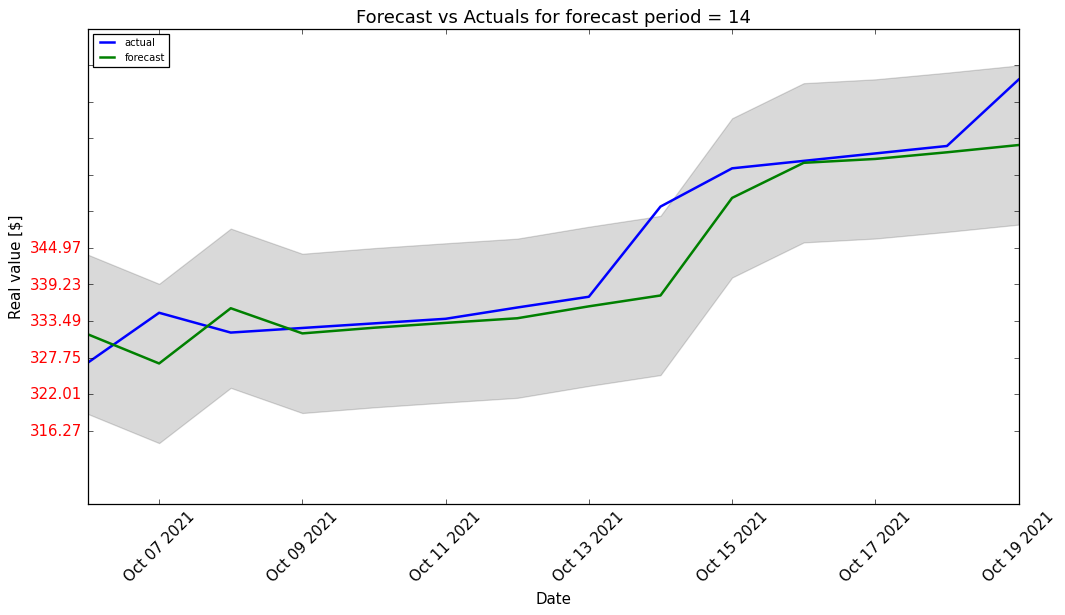

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(1,1,1)  1  1  1         7  0.008102
1     ACN  ARIMA(1,1,1)  1  1  1        14  0.006560


C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Forecast results for per=0
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.807561  0.011117       5.785772        5.82935
predicted=5.807561, expected=5.814198


C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Forecast results for per=1
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.814906  0.011116       5.793119       5.836694
predicted=5.814906, expected=5.833852


C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Forecast results for per=2
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.835847  0.011119       5.814055       5.857639
predicted=5.835847, expected=5.827775
Forecast results for per=3
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.827638  0.011118       5.805847       5.849429
predicted=5.827638, expected=5.823261
Forecast results for per=4
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.822809  0.011117        5.80102       5.844598
predicted=5.822809, expected=5.818727
Forecast results for per=5
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.818205  0.011116       5.796418       5.839992
predicted=5.818205, expected=5.814171


C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Forecast results for per=6
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.813633  0.011115       5.791848       5.835418
predicted=5.813633, expected=5.787579
Forecast results for per=7
y      mean  mean_se  mean_ci_lower  mean_ci_upper
0  5.784969  0.01112       5.763174       5.806764
predicted=5.784969, expected=5.782382
Forecast results for per=8
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.781329  0.011119       5.759536       5.803122
predicted=5.781329, expected=5.772633


C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Forecast results for per=9
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.771484  0.011119       5.749692       5.793277
predicted=5.771484, expected=5.779455
Forecast results for per=10
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.779845  0.011118       5.758054       5.801636
predicted=5.779845, expected=5.774111
Forecast results for per=11
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.773695  0.011117       5.751906       5.795485
predicted=5.773695, expected=5.768738
Forecast results for per=12
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.768143  0.011116       5.746355       5.789931
predicted=5.768143, expected=5.763336
Forecast results for per=13
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.762699  0.011116       5.740913       5.784485
predicted=5.762699, expected=5.784552
Forecast results for per=14
y    mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.7864  0.011119       5.764608       5.808193
predicted=5.786400, exp

C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Forecast results for per=15
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.778383  0.011118       5.756592       5.800174
predicted=5.778383, expected=5.792252
Forecast results for per=16
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.793496  0.011119       5.771704       5.815289
predicted=5.793496, expected=5.786836
Forecast results for per=17
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.786609  0.011118       5.764818         5.8084
predicted=5.786609, expected=5.788095


C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Forecast results for per=18
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.788161  0.011117       5.766372        5.80995
predicted=5.788161, expected=5.789351
Forecast results for per=19
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.789483  0.011116       5.767697        5.81127
predicted=5.789483, expected=5.790607
Forecast results for per=20
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.790753  0.011115       5.768968       5.812538
predicted=5.790753, expected=5.793695


C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Forecast results for per=21
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.794015  0.011114       5.772232       5.815797
predicted=5.794015, expected=5.796638
Forecast results for per=22
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.796983  0.011113       5.775203       5.818764
predicted=5.796983, expected=5.821311
Forecast results for per=23
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.823687  0.011117       5.801898       5.845475
predicted=5.823687, expected=5.831779
Forecast results for per=24
y     mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.83329  0.011116       5.811502       5.855078
predicted=5.833290, expected=5.833821
Forecast results for per=25
y     mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.83435  0.011115       5.812565       5.856136
predicted=5.834350, expected=5.835859
Forecast results for per=26
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  5.836168  0.011114       5.814385       5.857952
predicted=5.836168, ex

C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,prediction,se,lower_series,upper_series
0,5.807561,0.011117,5.785772,5.829350
1,5.814906,0.011116,5.793119,5.836694
2,5.835847,0.011119,5.814055,5.857639
3,5.827638,0.011118,5.805847,5.849429
4,5.822809,0.011117,5.801020,5.844598
5,5.818205,0.011116,5.796418,5.839992
6,5.813633,0.011115,5.791848,5.835418
7,5.784969,0.011120,5.763174,5.806764
8,5.781329,0.011119,5.759536,5.803122
9,5.771484,0.011119,5.749692,5.793277


3.285925749214768

5.856061292856436

step: 0.36716222052023834


3.285925749214768
3.6530879697350067
4.020250190255245
4.387412410775484
4.754574631295722
5.12173685181596
5.488899072336199
5.856061292856438


[3.29, 3.65, 4.02, 4.39, 4.75, 5.12, 5.49, 5.86]

3.285925749214768

5.856061292856436

26.733721584630885

349.34546122466844

step: 46.08739137714822


26.733721584630885
72.82111296177911
118.90850433892733
164.99589571607555
211.08328709322376
257.17067847037197
303.25806984752023
349.34546122466844


[26.73, 72.82, 118.91, 165.0, 211.08, 257.17, 303.26, 349.35]

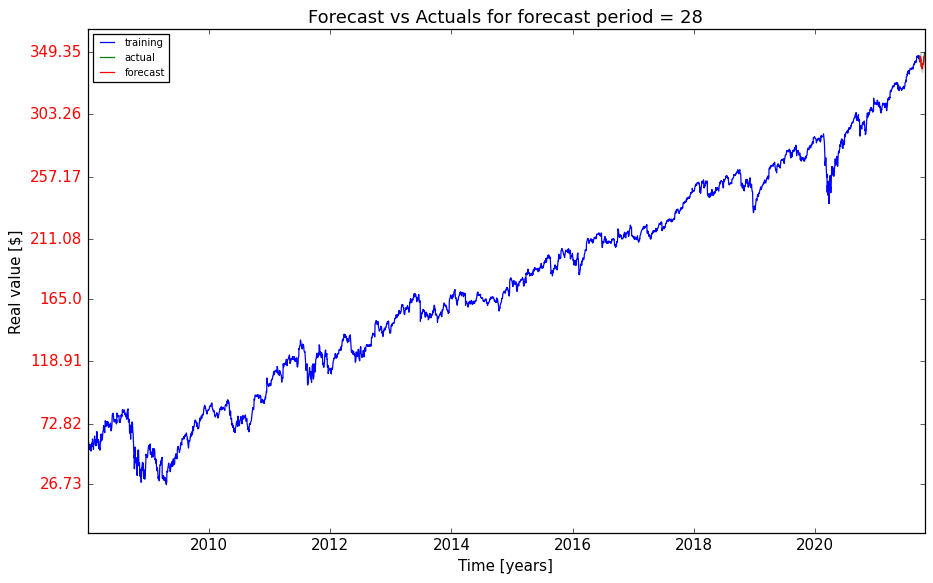

min value 5.740912931502681 max value 5.859933511064135
min value 5.74 max value 5.86
step: 0.02




'final y list'

[5.74, 5.76, 5.78, 5.8, 5.82, 5.84, 5.86]

min value 5.740912931502681 max value 5.859933511064135
min exp value 311.35 max exp value 350.7
step: 6.56




'final y exp list'

[311.35, 317.91, 324.47, 331.03, 337.59, 344.15]

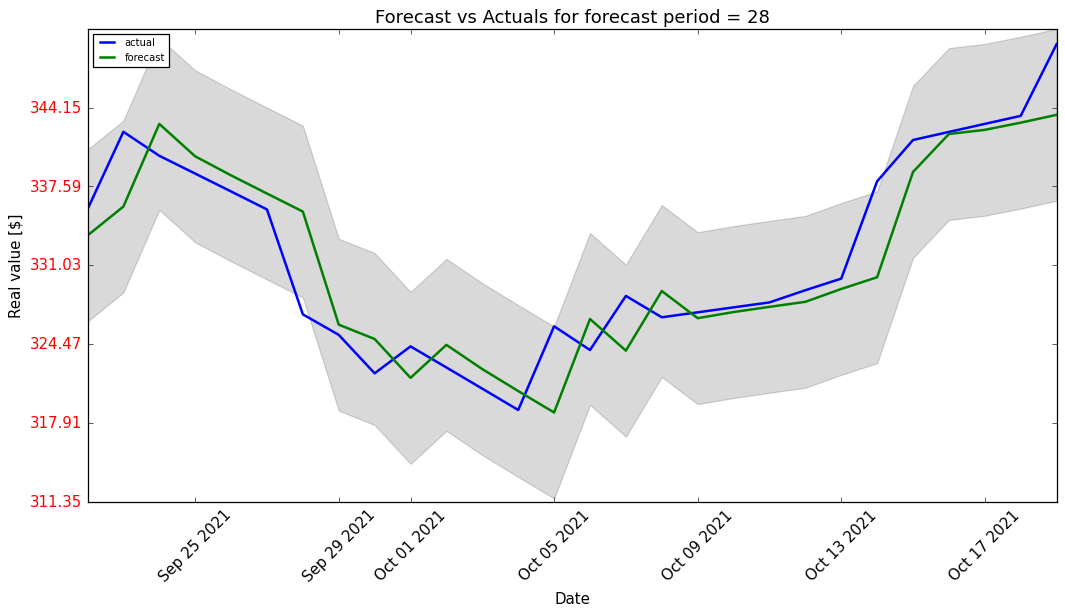

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(1,1,1)  1  1  1         7  0.008102
1     ACN  ARIMA(1,1,1)  1  1  1        14  0.006560
2     ACN  ARIMA(1,1,1)  1  1  1        28  0.007880
counter 1
AMZN


,timestamp,avg_price
0,2008-01-02,95.995534
1,2008-01-03,96.072367
2,2008-01-04,90.446724
3,2008-01-05,89.823779
4,2008-01-06,89.200835
...,...,...
4905,2021-07-03,3514.224080
4906,2021-07-04,3553.809078
4907,2021-07-05,3593.394076
4908,2021-07-06,3632.979074


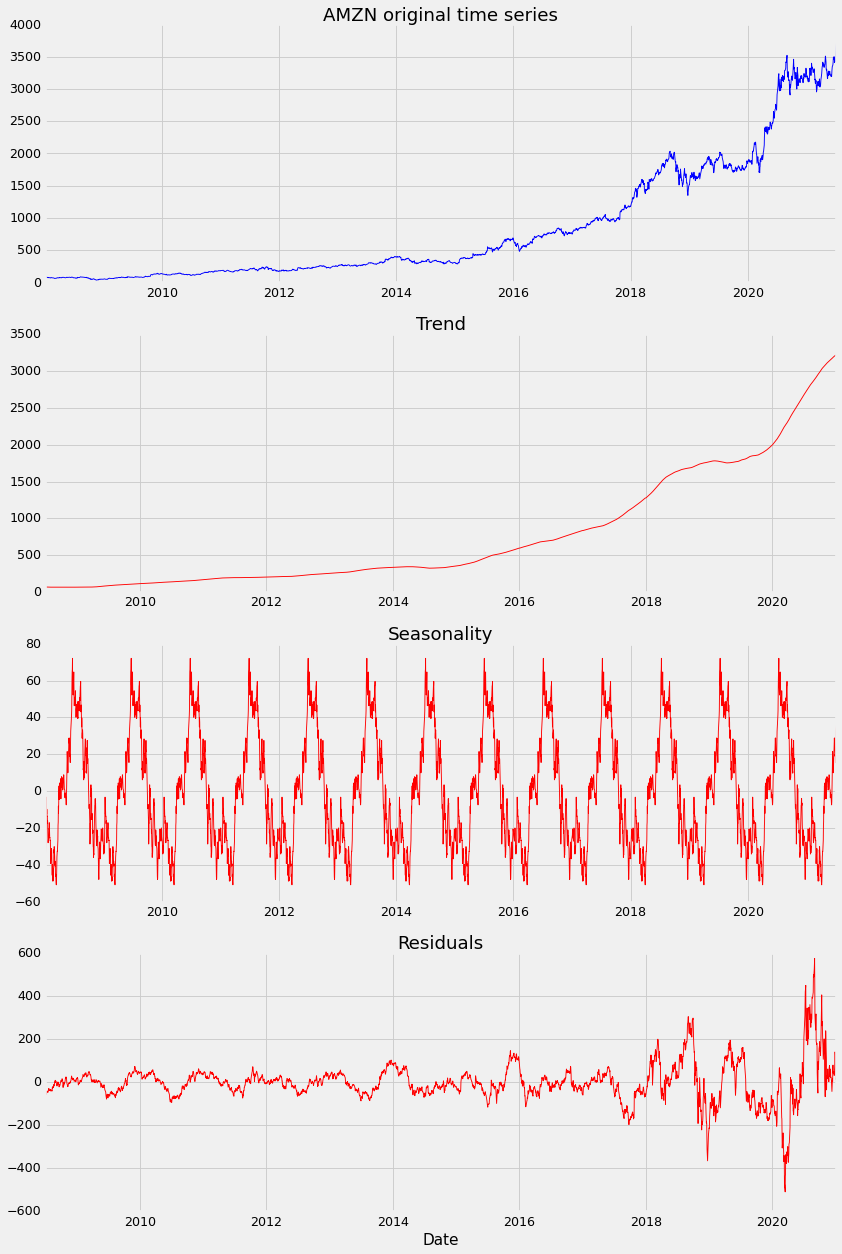

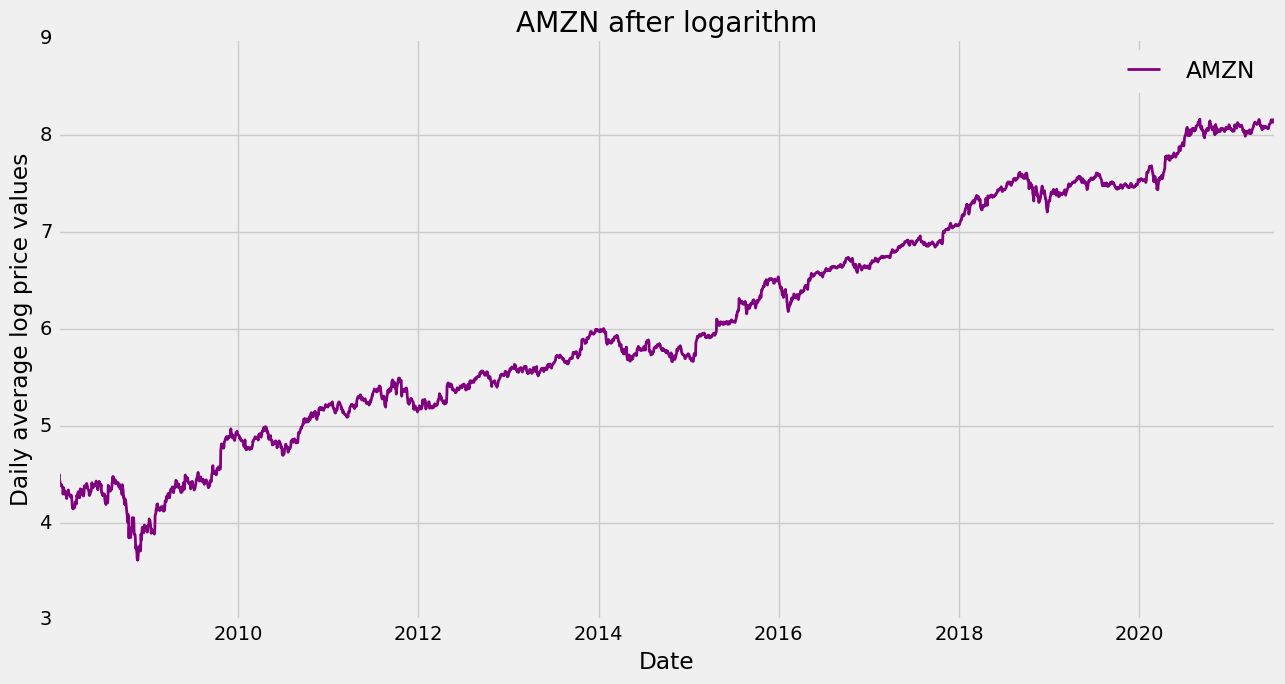

,timestamp,avg_price
0,2008-01-02,4.564302
1,2008-01-03,4.565102
2,2008-01-04,4.504761
3,2008-01-05,4.497850
4,2008-01-06,4.490890
...,...,...
4905,2021-07-03,8.164574
4906,2021-07-04,8.175775
4907,2021-07-05,8.186852
4908,2021-07-06,8.197808


0.17526683400371523 -3.4316838889956798


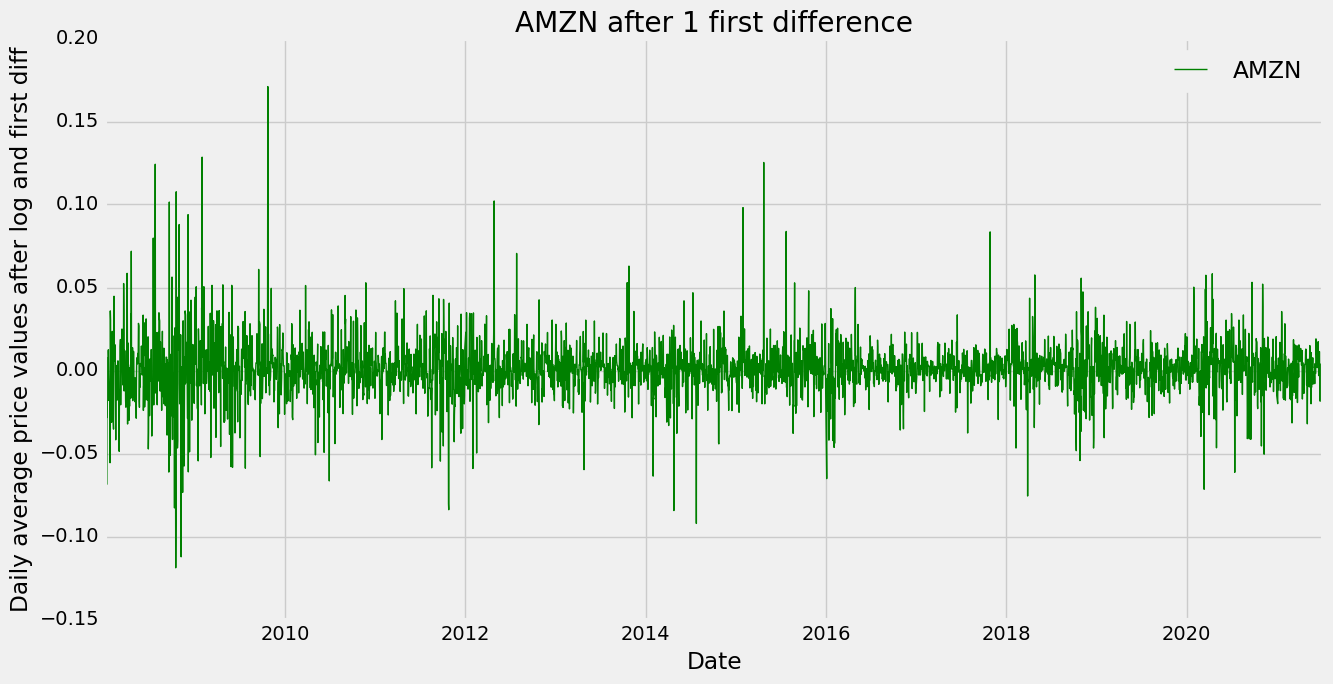

Number of first diff = 1
-34.30016791089735 -3.4316838889956798
Number of performed first diff = 1


'Original dataframe'

,timestamp,avg_price
0,2008-01-02,4.564302
1,2008-01-03,4.565102
2,2008-01-04,4.504761
3,2008-01-05,4.497850
4,2008-01-06,4.490890
...,...,...
4905,2021-07-03,8.164574
4906,2021-07-04,8.175775
4907,2021-07-05,8.186852
4908,2021-07-06,8.197808


'First differenced dataframe'

,timestamp,diff_price
0,2008-01-03,0.000800
1,2008-01-04,-0.060341
2,2008-01-05,-0.006911
3,2008-01-06,-0.006959
4,2008-01-07,-0.007008
...,...,...
4904,2021-07-03,0.011328
4905,2021-07-04,0.011201
4906,2021-07-05,0.011077
4907,2021-07-06,0.010956


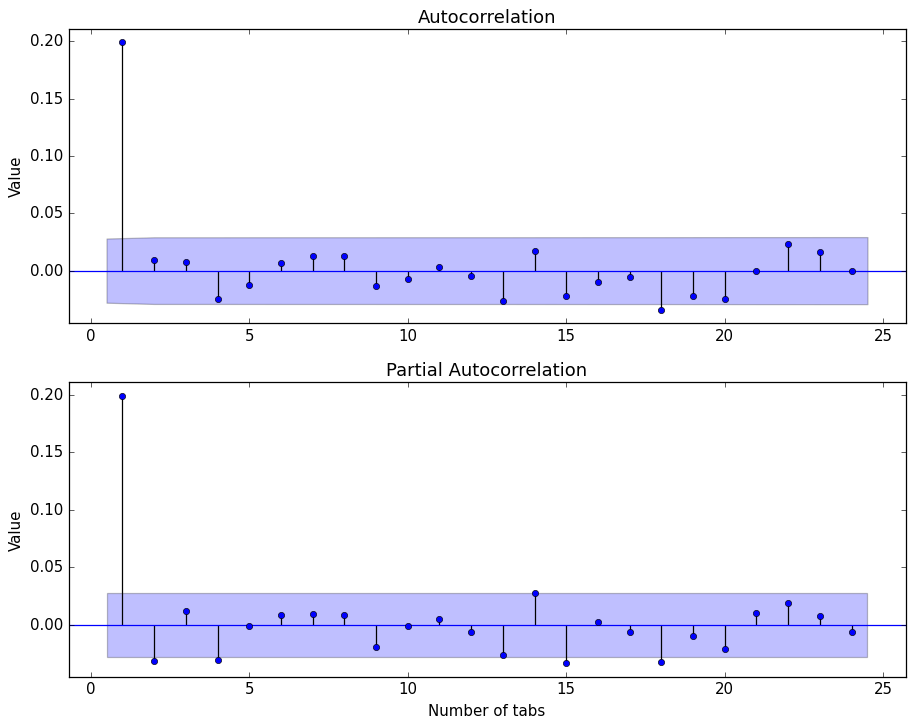

[-24900.23028495728, -27188.003382410054, -25672.16828399752, -27387.909896882724]
[-24893.73186692119, -27175.006953960416, -25659.17144792534, -27368.41525420827]


C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,ARIMA,p,d,q,AIC,BIC
0,"ARIMA(0,1,0)",0,1,0,-24900.230285,-24893.731867
1,"ARIMA(0,1,1)",0,1,1,-27188.003382,-27175.006954
2,"ARIMA(1,1,0)",1,1,0,-25672.168284,-25659.171448
3,"ARIMA(1,1,1)",1,1,1,-27387.909897,-27368.415254


Best ARIMA according to AIC criterium:
ARIMA    ARIMA(1,1,1)
p                   1
d                   1
q                   1
AIC          -27387.9
BIC          -27368.4
Name: 3, dtype: object

Best ARIMA according to BIC criterium:
ARIMA    ARIMA(1,1,1)
p                   1
d                   1
q                   1
AIC          -27387.9
BIC          -27368.4
Name: 3, dtype: object


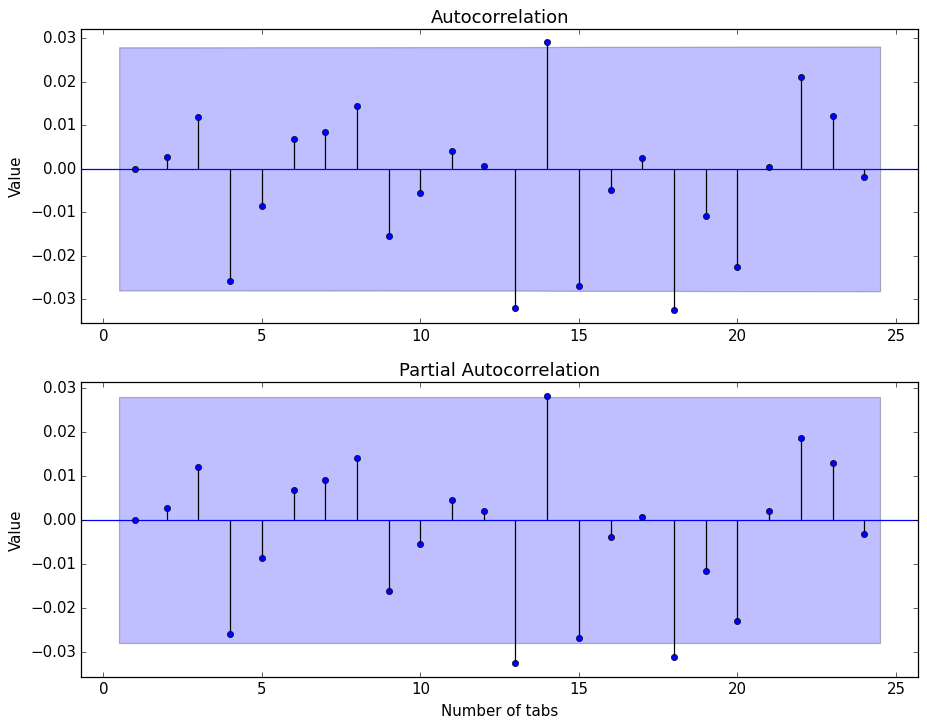

Forecast results for per=0
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.148646  0.014836       8.119569       8.177723
predicted=8.148646, expected=8.140345
Forecast results for per=1
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.138662  0.014835       8.109587       8.167737
predicted=8.138662, expected=8.153246
Forecast results for per=2
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.156185  0.014834        8.12711        8.18526
predicted=8.156185, expected=8.164574
Forecast results for per=3
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.166464  0.014833       8.137391       8.195537
predicted=8.166464, expected=8.175775
Forecast results for per=4
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.177805  0.014833       8.148734       8.206877
predicted=8.177805, expected=8.186852
Forecast results for per=5
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.188837  0.014832       8.159767       8.217906
predicted=8.188837, expe

,prediction,se,lower_series,upper_series
0,8.148646,0.014836,8.119569,8.177723
1,8.138662,0.014835,8.109587,8.167737
2,8.156185,0.014834,8.127110,8.185260
3,8.166464,0.014833,8.137391,8.195537
4,8.177805,0.014833,8.148734,8.206877
5,8.188837,0.014832,8.159767,8.217906
6,8.199776,0.014831,8.170709,8.228844


3.6146300361494115

8.217536215469567

step: 0.657558025617165


3.6146300361494115
4.272188061766577
4.929746087383742
5.587304113000907
6.244862138618072
6.902420164235237
7.559978189852402
8.217536215469568


[3.61, 4.27, 4.93, 5.59, 6.24, 6.9, 7.56, 8.22]

3.6146300361494115

8.217536215469567

37.137603812852554

3705.3619136995685

step: 524.0320442695308


37.137603812852554
561.1696480823834
1085.2016923519143
1609.2337366214451
2133.2657808909757
2657.297825160507
3181.3298694300374
3705.361913699568


[37.14, 561.17, 1085.2, 1609.23, 2133.27, 2657.3, 3181.33, 3705.36]

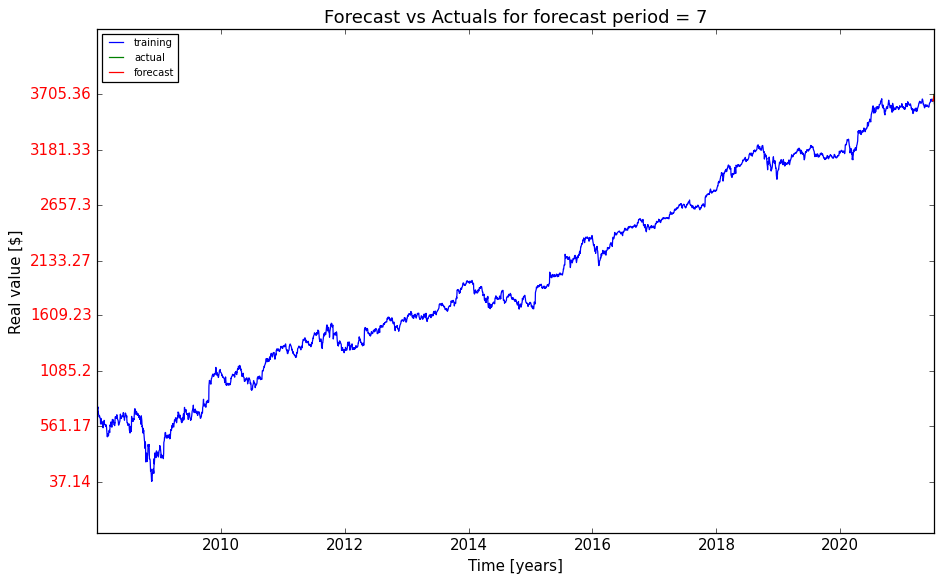

min value 8.10958722991963 max value 8.228843530166683
min value 8.11 max value 8.23
step: 0.02




'final y list'

[8.11, 8.13, 8.15, 8.17, 8.19, 8.21, 8.23, 8.25]

min value 8.10958722991963 max value 8.228843530166683
min exp value 3326.2 max exp value 3747.5
step: 70.22




'final y exp list'

[3326.2, 3396.42, 3466.64, 3536.86, 3607.08, 3677.3]

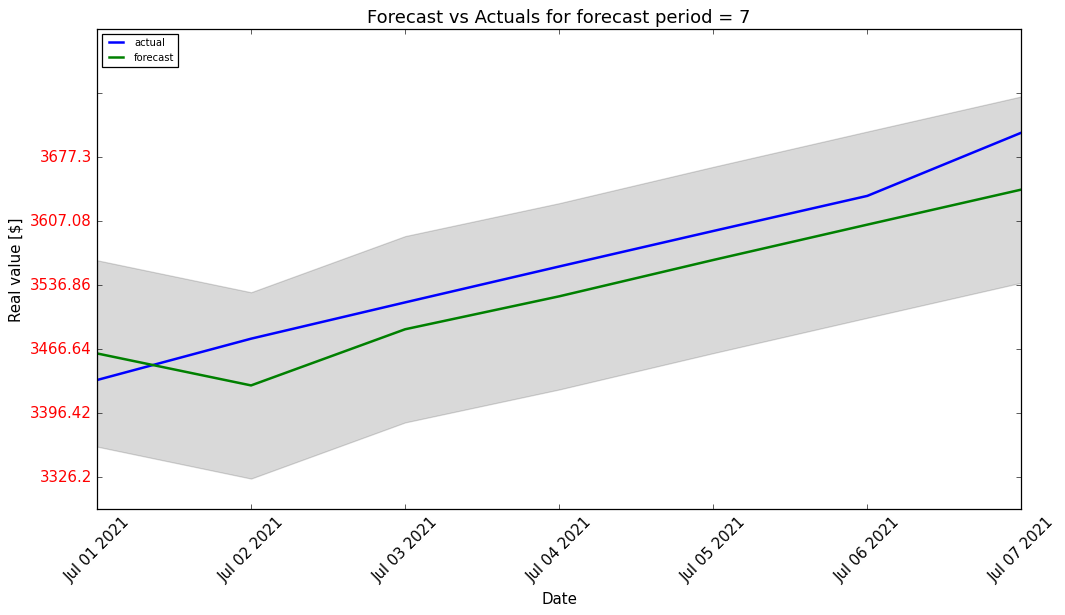

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(1,1,1)  1  1  1         7  0.008102
1     ACN  ARIMA(1,1,1)  1  1  1        14  0.006560
2     ACN  ARIMA(1,1,1)  1  1  1        28  0.007880
3    AMZN  ARIMA(1,1,1)  1  1  1         7  0.010909
Forecast results for per=0
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.160384  0.014843       8.131291       8.189476
predicted=8.160384, expected=8.152833
Forecast results for per=1
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.151249  0.014842       8.122158       8.180339
predicted=8.151249, expected=8.134347
Forecast results for per=2
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.130756  0.014843       8.101665       8.159847
predicted=8.130756, expected=8.136574
Forecast results for per=3
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.137599  0.014841        8.10851       8.166687
predicted=8.137599, expected=8.138796
Forecast results for per=4
y      mean  mean_se  mean_ci_lo

,prediction,se,lower_series,upper_series
0,8.160384,0.014843,8.131291,8.189476
1,8.151249,0.014842,8.122158,8.180339
2,8.130756,0.014843,8.101665,8.159847
3,8.137599,0.014841,8.108510,8.166687
4,8.139097,0.014840,8.110011,8.168183
5,8.141427,0.014838,8.112344,8.170510
6,8.144173,0.014837,8.115093,8.173253
7,8.148646,0.014836,8.119569,8.177723
8,8.138662,0.014835,8.109587,8.167737
9,8.156185,0.014834,8.127110,8.185260


3.6146300361494115

8.217536215469567

step: 0.657558025617165


3.6146300361494115
4.272188061766577
4.929746087383742
5.587304113000907
6.244862138618072
6.902420164235237
7.559978189852402
8.217536215469568


[3.61, 4.27, 4.93, 5.59, 6.24, 6.9, 7.56, 8.22]

3.6146300361494115

8.217536215469567

37.137603812852554

3705.3619136995685

step: 524.0320442695308


37.137603812852554
561.1696480823834
1085.2016923519143
1609.2337366214451
2133.2657808909757
2657.297825160507
3181.3298694300374
3705.361913699568


[37.14, 561.17, 1085.2, 1609.23, 2133.27, 2657.3, 3181.33, 3705.36]

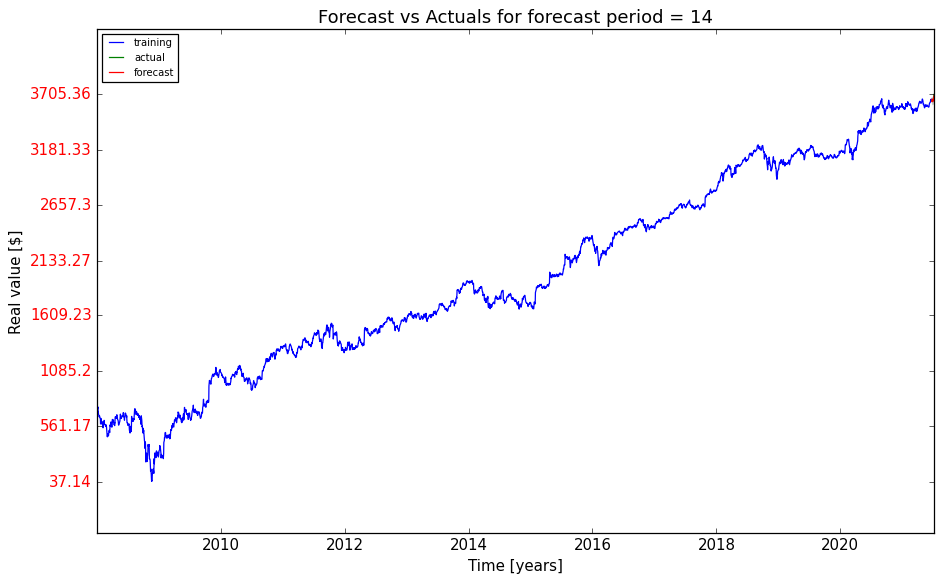

min value 8.101664633777814 max value 8.228843530166683
min value 8.1 max value 8.23
step: 0.02




'final y list'

[8.1, 8.12, 8.14, 8.16, 8.18, 8.2, 8.22, 8.24]

min value 8.101664633777814 max value 8.228843530166683
min exp value 3299.96 max exp value 3747.5
step: 74.59




'final y exp list'

[3299.96, 3374.55, 3449.14, 3523.73, 3598.32, 3672.91]

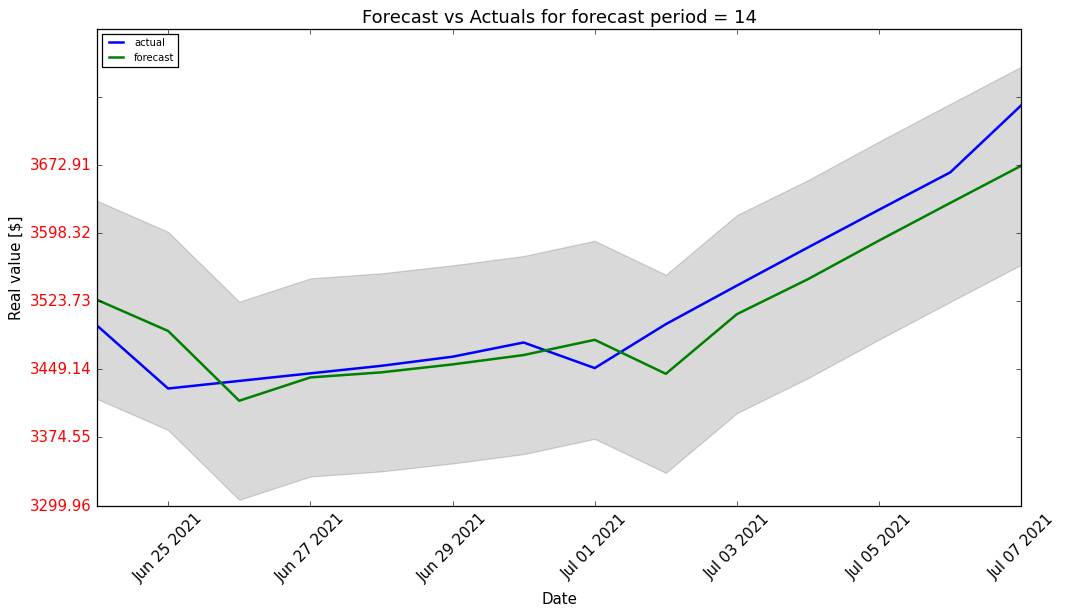

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(1,1,1)  1  1  1         7  0.008102
1     ACN  ARIMA(1,1,1)  1  1  1        14  0.006560
2     ACN  ARIMA(1,1,1)  1  1  1        28  0.007880
3    AMZN  ARIMA(1,1,1)  1  1  1         7  0.010909
4    AMZN  ARIMA(1,1,1)  1  1  1        14  0.008263
Forecast results for per=0
y      mean  mean_se  mean_ci_lower  mean_ci_upper
0  8.099127  0.01486       8.070002       8.128252
predicted=8.099127, expected=8.109667
Forecast results for per=1
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.111925  0.014859       8.082801       8.141049
predicted=8.111925, expected=8.115852
Forecast results for per=2
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.116782  0.014858       8.087661       8.145903
predicted=8.116782, expected=8.117675
Forecast results for per=3
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.117908  0.014857        8.08879       8.147027
predicted=8.117908, expected=8.119496
Forecast

C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Forecast results for per=11
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.151675  0.014847       8.122576       8.180774
predicted=8.151675, expected=8.149119
Forecast results for per=12
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.148563  0.014845       8.119467        8.17766
predicted=8.148563, expected=8.160527
Forecast results for per=13
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.162982  0.014845       8.133887       8.192078
predicted=8.162982, expected=8.160726
Forecast results for per=14
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.160384  0.014843       8.131291       8.189476
predicted=8.160384, expected=8.152833
Forecast results for per=15
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.151249  0.014842       8.122158       8.180339
predicted=8.151249, expected=8.134347
Forecast results for per=16
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  8.130756  0.014843       8.101665       8.159847
predicted=8.130756

,prediction,se,lower_series,upper_series
0,8.099127,0.014860,8.070002,8.128252
1,8.111925,0.014859,8.082801,8.141049
2,8.116782,0.014858,8.087661,8.145903
3,8.117908,0.014857,8.088790,8.147027
4,8.119837,0.014855,8.090721,8.148952
5,8.121636,0.014854,8.092524,8.150748
6,8.125795,0.014852,8.096686,8.154905
7,8.133264,0.014851,8.104157,8.162371
8,8.152703,0.014851,8.123595,8.181811
9,8.159594,0.014850,8.130489,8.188699


3.6146300361494115

8.217536215469567

step: 0.657558025617165


3.6146300361494115
4.272188061766577
4.929746087383742
5.587304113000907
6.244862138618072
6.902420164235237
7.559978189852402
8.217536215469568


[3.61, 4.27, 4.93, 5.59, 6.24, 6.9, 7.56, 8.22]

3.6146300361494115

8.217536215469567

37.137603812852554

3705.3619136995685

step: 524.0320442695308


37.137603812852554
561.1696480823834
1085.2016923519143
1609.2337366214451
2133.2657808909757
2657.297825160507
3181.3298694300374
3705.361913699568


[37.14, 561.17, 1085.2, 1609.23, 2133.27, 2657.3, 3181.33, 3705.36]

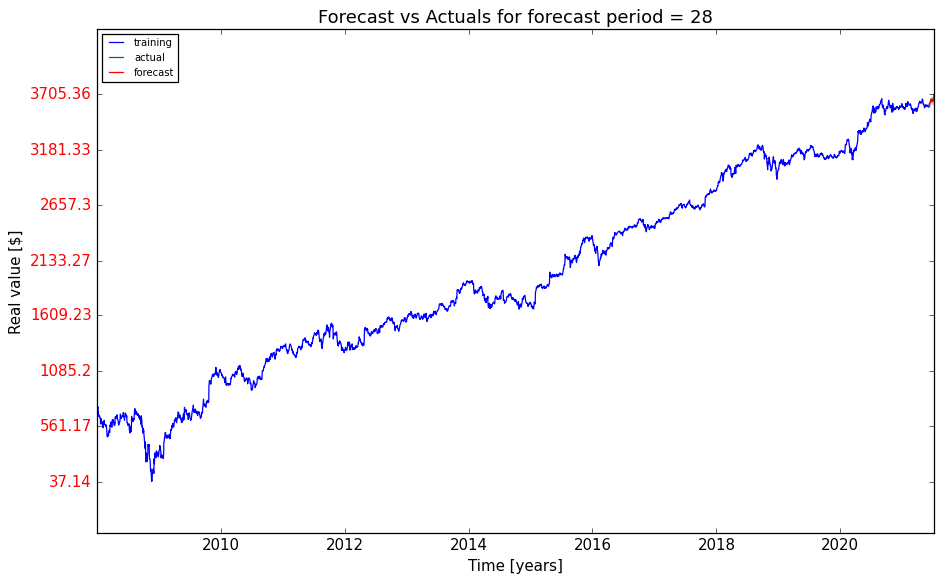

min value 8.070001514935585 max value 8.228843530166683
min value 8.07 max value 8.23
step: 0.02




'final y list'

[8.07, 8.09, 8.11, 8.13, 8.15, 8.17, 8.19, 8.21, 8.23]

min value 8.070001514935585 max value 8.228843530166683
min exp value 3197.11 max exp value 3747.5
step: 91.73




'final y exp list'

[3197.11, 3288.84, 3380.57, 3472.3, 3564.03, 3655.76, 3747.49]

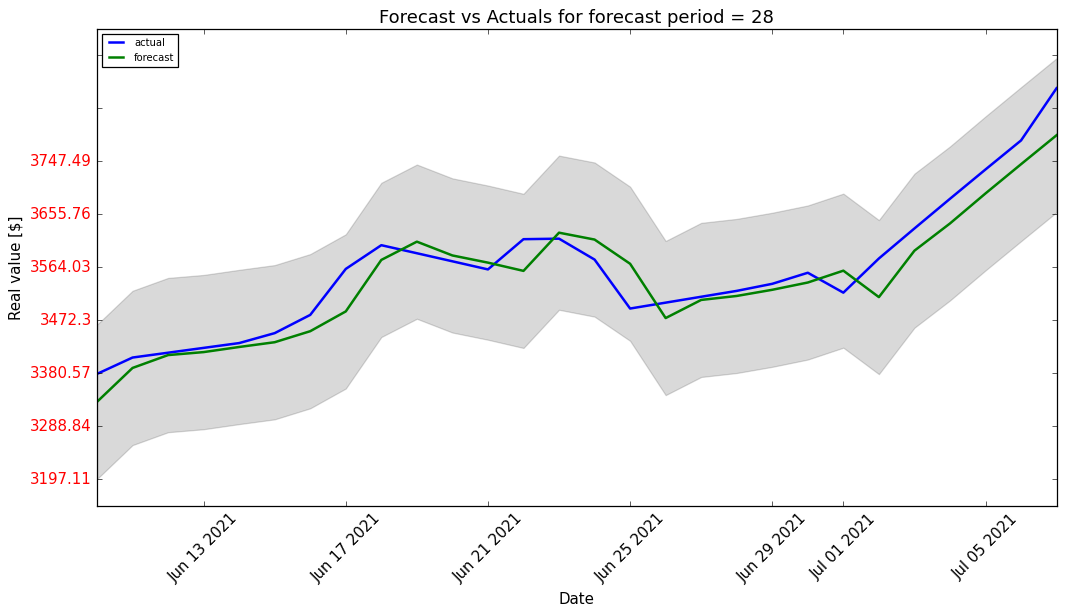

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(1,1,1)  1  1  1         7  0.008102
1     ACN  ARIMA(1,1,1)  1  1  1        14  0.006560
2     ACN  ARIMA(1,1,1)  1  1  1        28  0.007880
3    AMZN  ARIMA(1,1,1)  1  1  1         7  0.010909
4    AMZN  ARIMA(1,1,1)  1  1  1        14  0.008263
5    AMZN  ARIMA(1,1,1)  1  1  1        28  0.006738
counter 2
ARCB


,timestamp,avg_price
0,2014-05-01,39.041370
1,2014-05-02,38.674239
2,2014-05-03,38.919088
3,2014-05-04,39.163938
4,2014-05-05,39.408787
...,...,...
2718,2021-10-24,89.261799
2719,2021-10-25,89.564201
2720,2021-10-26,89.723779
2721,2021-10-27,87.879773


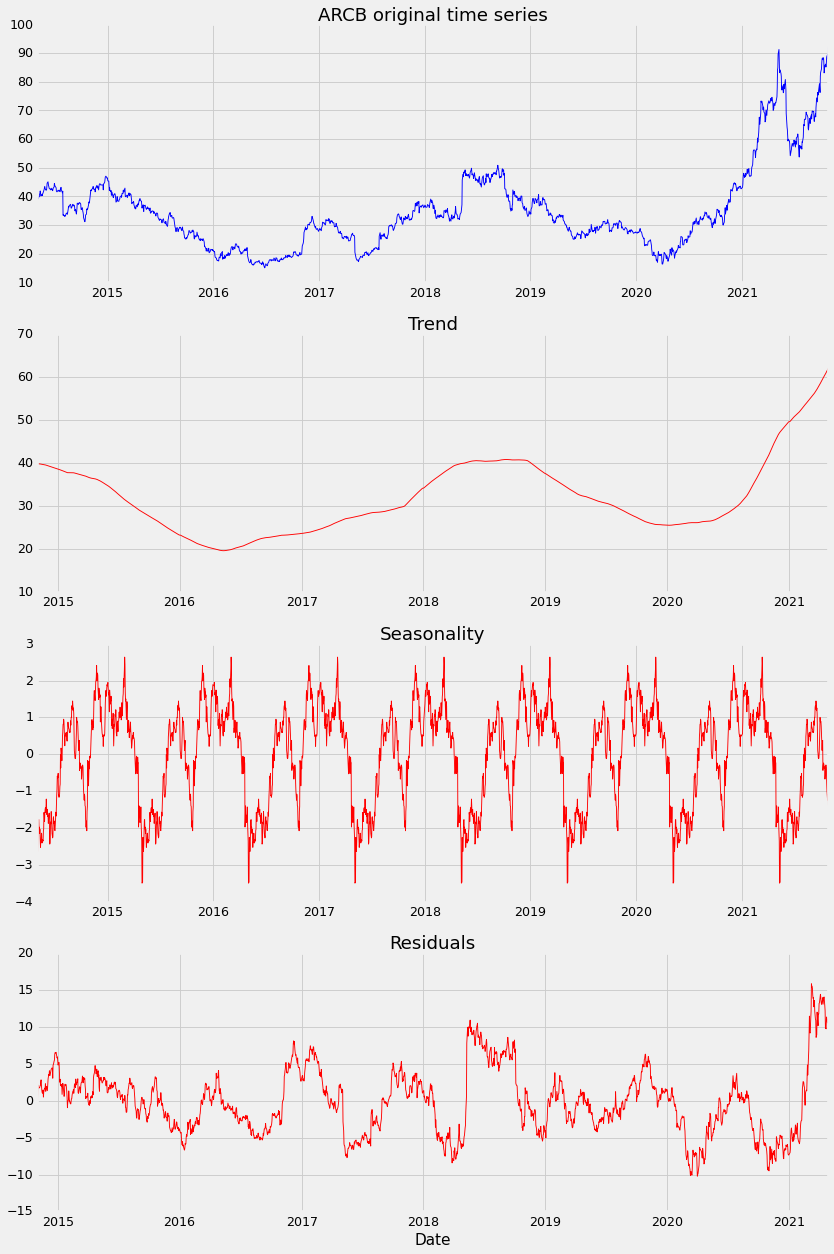

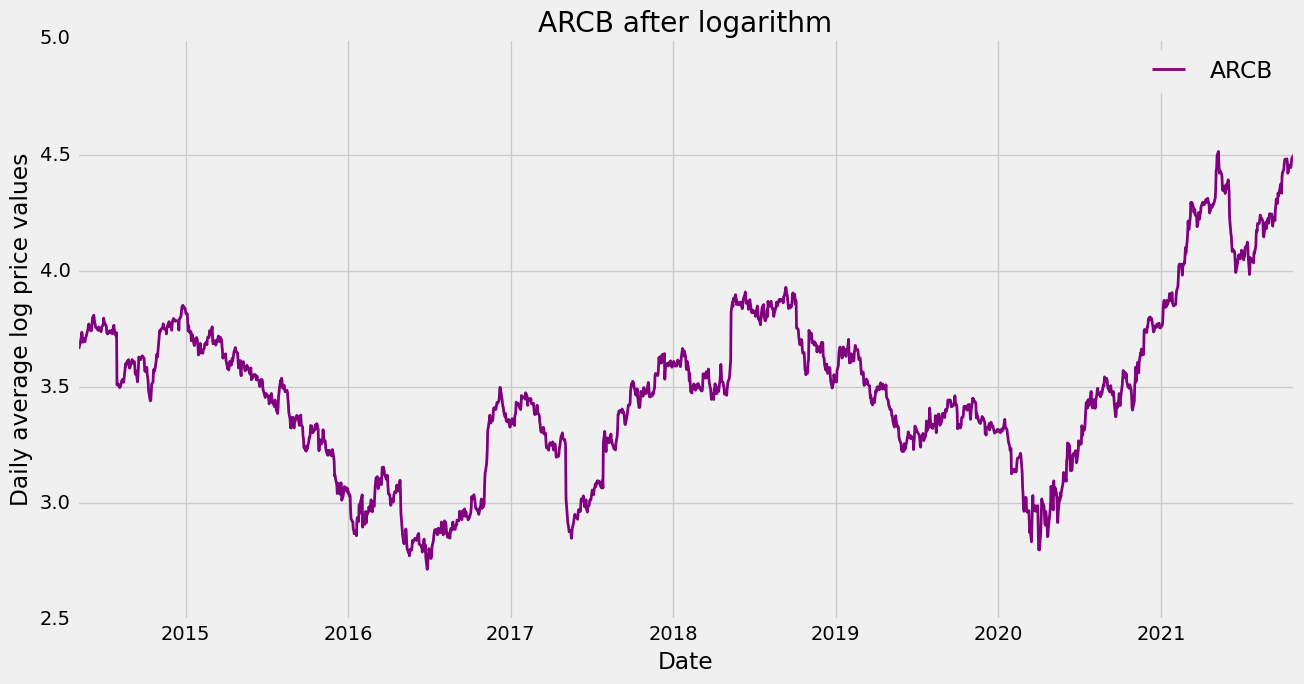

,timestamp,avg_price
0,2014-05-01,3.664622
1,2014-05-02,3.655174
2,2014-05-03,3.661485
3,2014-05-04,3.667756
4,2014-05-05,3.673989
...,...,...
2718,2021-10-24,4.491574
2719,2021-10-25,4.494956
2720,2021-10-26,4.496736
2721,2021-10-27,4.475970


-0.5330597791637616 -3.432755542000777


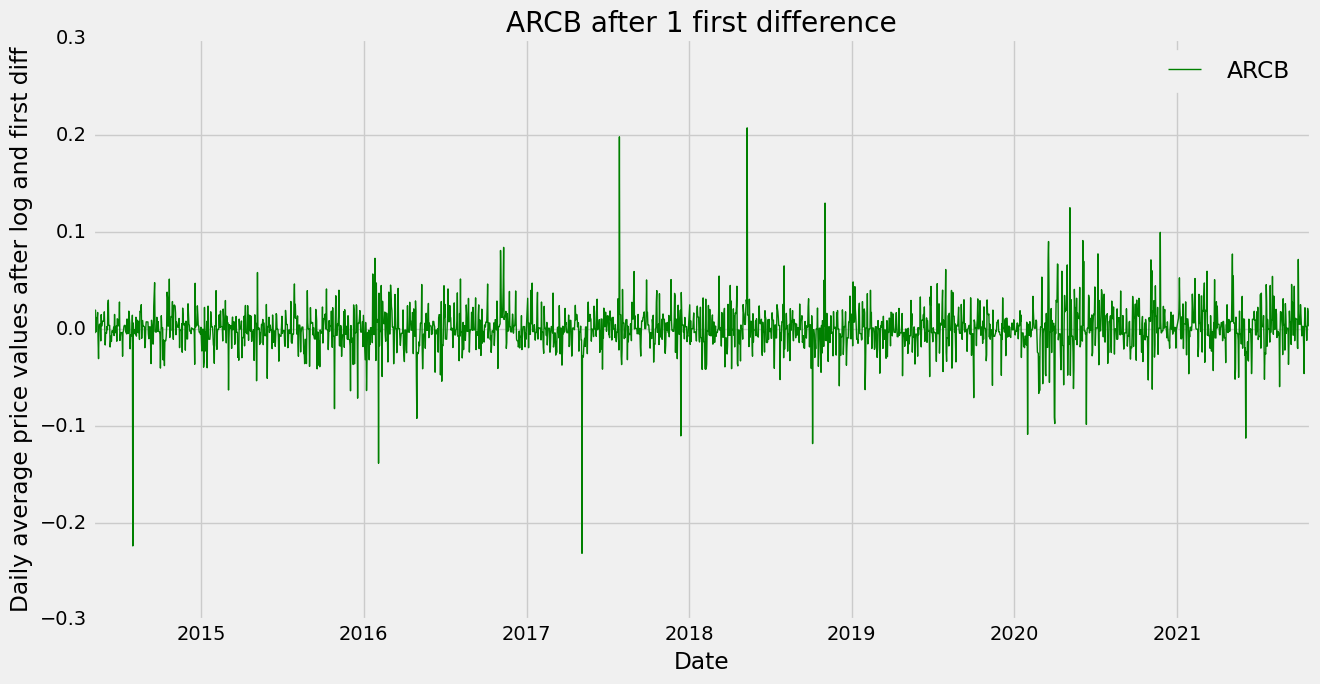

Number of first diff = 1
-45.62295848254238 -3.432755542000777
Number of performed first diff = 1


'Original dataframe'

,timestamp,avg_price
0,2014-05-01,3.664622
1,2014-05-02,3.655174
2,2014-05-03,3.661485
3,2014-05-04,3.667756
4,2014-05-05,3.673989
...,...,...
2718,2021-10-24,4.491574
2719,2021-10-25,4.494956
2720,2021-10-26,4.496736
2721,2021-10-27,4.475970


'First differenced dataframe'

,timestamp,diff_price
0,2014-05-02,-0.009448
1,2014-05-03,0.006311
2,2014-05-04,0.006272
3,2014-05-05,0.006232
4,2014-05-06,-0.004375
...,...,...
2717,2021-10-24,0.003394
2718,2021-10-25,0.003382
2719,2021-10-26,0.001780
2720,2021-10-27,-0.020766


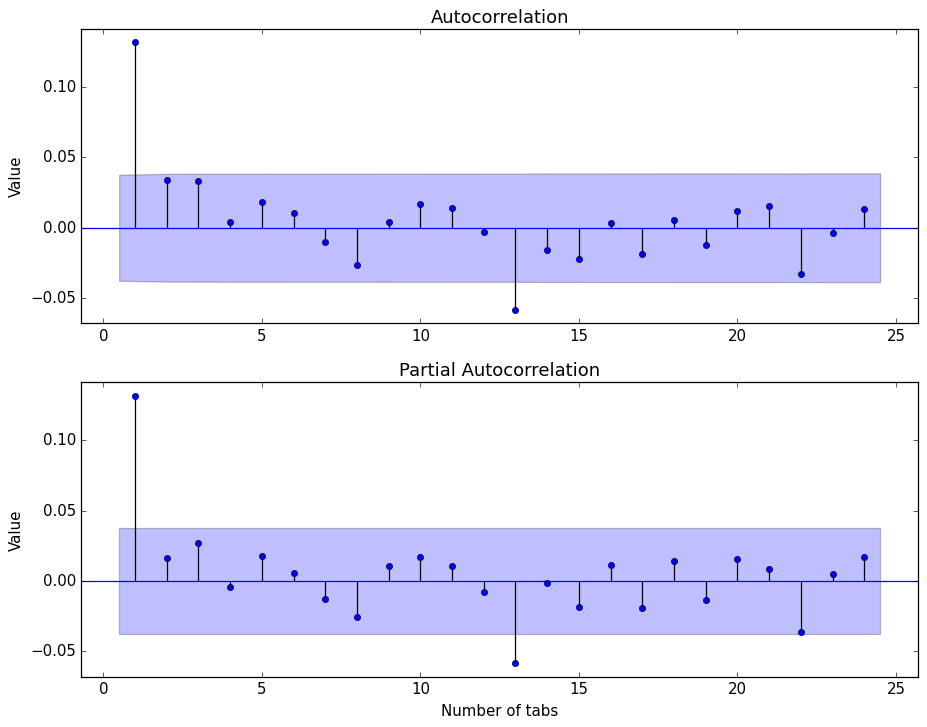

[-11804.307004595496, -13289.260241589416, -12396.33034165425, -13333.714758045024]
[-11798.398617436205, -13277.444202700151, -12384.513567335669, -13315.990699711127]


,ARIMA,p,d,q,AIC,BIC
0,"ARIMA(0,1,0)",0,1,0,-11804.307005,-11798.398617
1,"ARIMA(0,1,1)",0,1,1,-13289.260242,-13277.444203
2,"ARIMA(1,1,0)",1,1,0,-12396.330342,-12384.513567
3,"ARIMA(1,1,1)",1,1,1,-13333.714758,-13315.990700


Best ARIMA according to AIC criterium:
ARIMA    ARIMA(1,1,1)
p                   1
d                   1
q                   1
AIC          -13333.7
BIC            -13316
Name: 3, dtype: object

Best ARIMA according to BIC criterium:
ARIMA    ARIMA(1,1,1)
p                   1
d                   1
q                   1
AIC          -13333.7
BIC            -13316
Name: 3, dtype: object


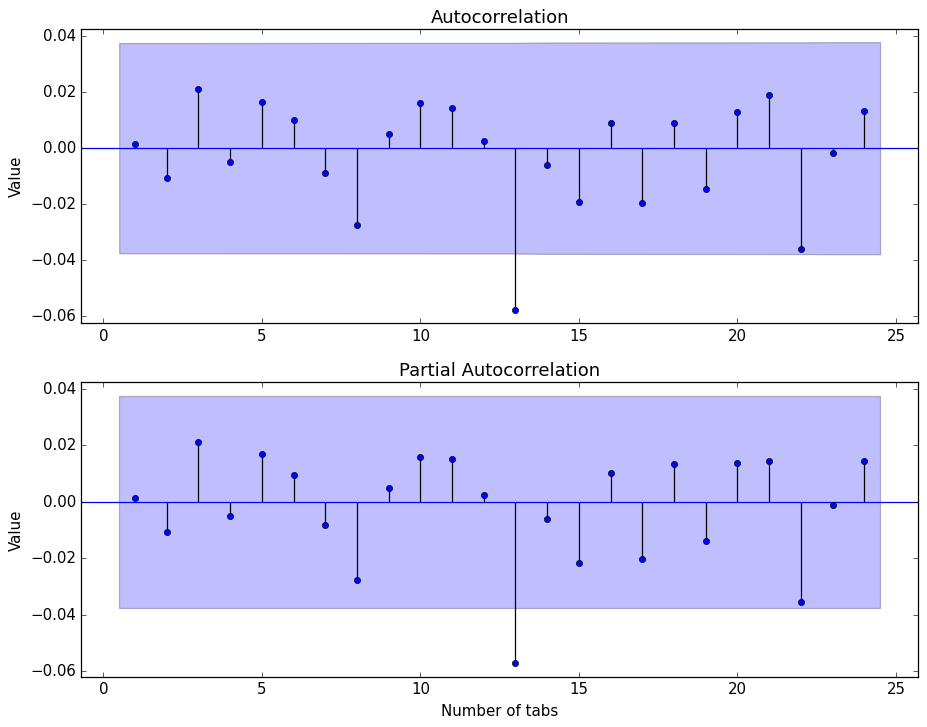

Forecast results for per=0
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  4.469681  0.020772       4.428969       4.510393
predicted=4.469681, expected=4.484775
Forecast results for per=1
y      mean  mean_se  mean_ci_lower  mean_ci_upper
0  4.487508  0.02077       4.446799       4.528216
predicted=4.487508, expected=4.488180
Forecast results for per=2
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  4.489024  0.020766       4.448323       4.529725
predicted=4.489024, expected=4.491574
Forecast results for per=3
y     mean   mean_se  mean_ci_lower  mean_ci_upper
0  4.49214  0.020762       4.451446       4.532834
predicted=4.492140, expected=4.494956
Forecast results for per=4
y     mean   mean_se  mean_ci_lower  mean_ci_upper
0  4.49548  0.020759       4.454794       4.536166
predicted=4.495480, expected=4.496736
Forecast results for per=5
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  4.497045  0.020755       4.456366       4.537724
predicted=4.497045, expected=4

,prediction,se,lower_series,upper_series
0,4.469681,0.020772,4.428969,4.510393
1,4.487508,0.020770,4.446799,4.528216
2,4.489024,0.020766,4.448323,4.529725
3,4.492140,0.020762,4.451446,4.532834
4,4.495480,0.020759,4.454794,4.536166
5,4.497045,0.020755,4.456366,4.537724
6,4.473308,0.020755,4.432629,4.513987


2.7159613358862242

4.52473071657285

step: 0.2583956258123751


2.7159613358862242
2.974356961698599
3.232752587510974
3.491148213323349
3.749543839135724
4.007939464948099
4.2663350907604745
4.524730716572849
4.7831263423852235


[2.72, 2.97, 3.23, 3.49, 3.75, 4.01, 4.27, 4.52, 4.78]

2.7159613358862242

4.52473071657285

15.11913765743077

92.27107541149164

step: 11.021705393437268


15.11913765743077
26.140843050868035
37.1625484443053
48.18425383774257
59.20595923117983
70.22766462461709
81.24937001805436
92.27107541149164


[15.12, 26.14, 37.16, 48.18, 59.21, 70.23, 81.25, 92.27]

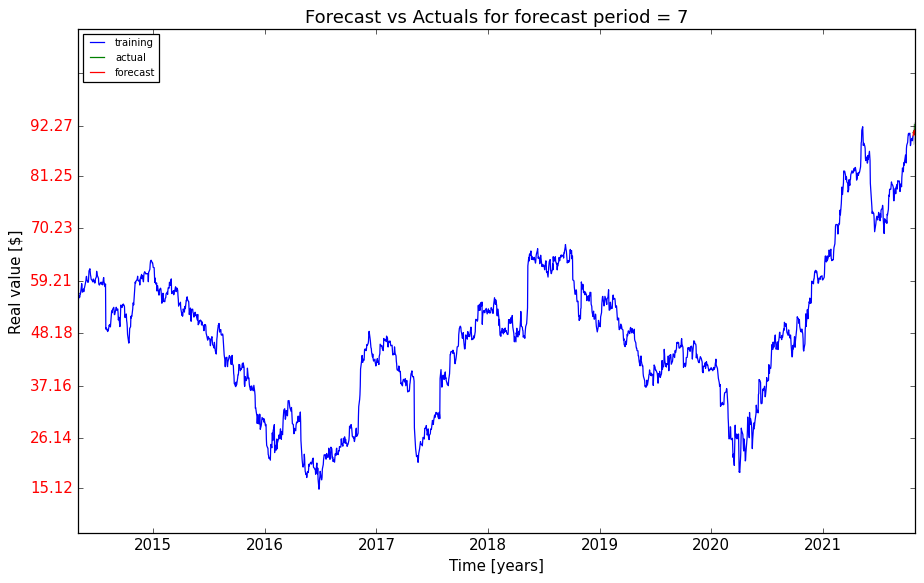

min value 4.428968880513905 max value 4.537723871565626
min value 4.43 max value 4.54
step: 0.02




'final y list'

[4.43, 4.45, 4.47, 4.49, 4.51, 4.53, 4.55]

min value 4.428968880513905 max value 4.537723871565626
min exp value 83.84 max exp value 93.48
step: 1.61




'final y exp list'

[83.84, 85.45, 87.06, 88.67, 90.28, 91.89]

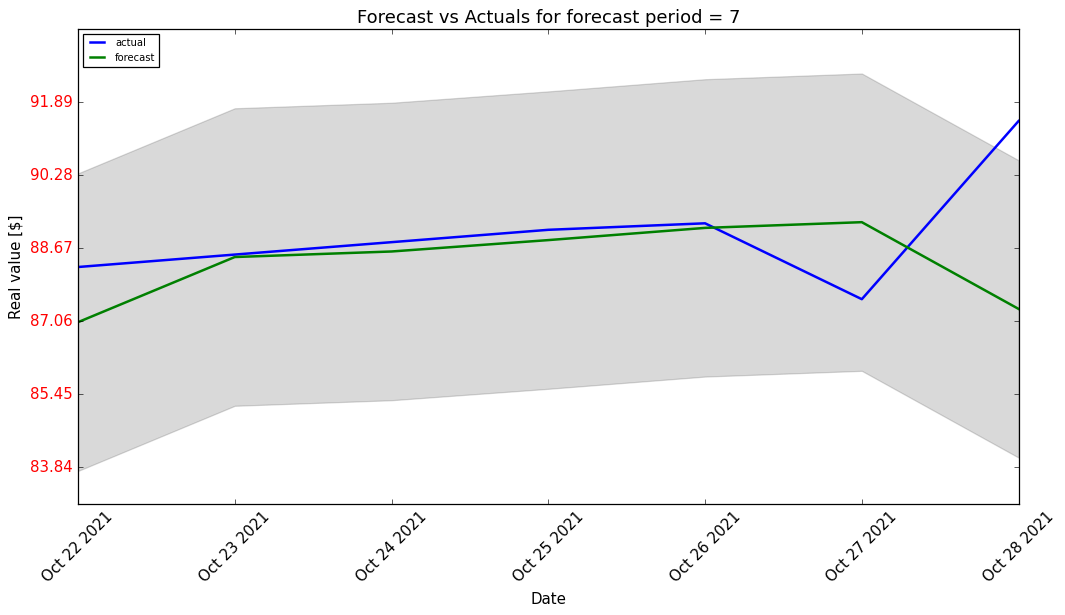

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(1,1,1)  1  1  1         7  0.008102
1     ACN  ARIMA(1,1,1)  1  1  1        14  0.006560
2     ACN  ARIMA(1,1,1)  1  1  1        28  0.007880
3    AMZN  ARIMA(1,1,1)  1  1  1         7  0.010909
4    AMZN  ARIMA(1,1,1)  1  1  1        14  0.008263
5    AMZN  ARIMA(1,1,1)  1  1  1        28  0.006738
6    ARCB  ARIMA(1,1,1)  1  1  1         7  0.013555
Forecast results for per=0
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  4.426361  0.020789       4.385616       4.467107
predicted=4.426361, expected=4.448477
Forecast results for per=1
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  4.451313  0.020789       4.410567        4.49206
predicted=4.451313, expected=4.451109
Forecast results for per=2
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  4.451873  0.020785       4.411134       4.492612
predicted=4.451873, expected=4.453734
Forecast results for per=3
y     mean   mean_se  mean_ci_lower  mean_

,prediction,se,lower_series,upper_series
0,4.426361,0.020789,4.385616,4.467107
1,4.451313,0.020789,4.410567,4.492060
2,4.451873,0.020785,4.411134,4.492612
3,4.454190,0.020782,4.413458,4.494921
4,4.456761,0.020778,4.416037,4.497485
5,4.443083,0.020775,4.402364,4.483802
6,4.445516,0.020772,4.404804,4.486227
7,4.469681,0.020772,4.428969,4.510393
8,4.487508,0.020770,4.446799,4.528216
9,4.489024,0.020766,4.448323,4.529725


2.7159613358862242

4.52473071657285

step: 0.2583956258123751


2.7159613358862242
2.974356961698599
3.232752587510974
3.491148213323349
3.749543839135724
4.007939464948099
4.2663350907604745
4.524730716572849
4.7831263423852235


[2.72, 2.97, 3.23, 3.49, 3.75, 4.01, 4.27, 4.52, 4.78]

2.7159613358862242

4.52473071657285

15.11913765743077

92.27107541149164

step: 11.021705393437268


15.11913765743077
26.140843050868035
37.1625484443053
48.18425383774257
59.20595923117983
70.22766462461709
81.24937001805436
92.27107541149164


[15.12, 26.14, 37.16, 48.18, 59.21, 70.23, 81.25, 92.27]

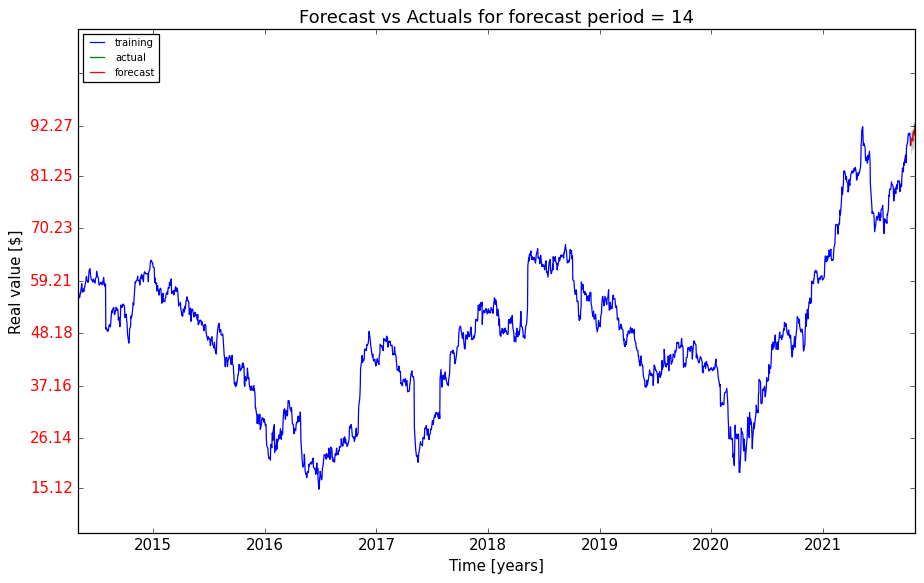

min value 4.385616203305578 max value 4.537723871565626
min value 4.39 max value 4.54
step: 0.02




'final y list'

[4.39, 4.41, 4.43, 4.45, 4.47, 4.49, 4.51, 4.53, 4.55]

min value 4.385616203305578 max value 4.537723871565626
min exp value 80.29 max exp value 93.48
step: 2.2




'final y exp list'

[80.29, 82.49, 84.69, 86.89, 89.09, 91.29]

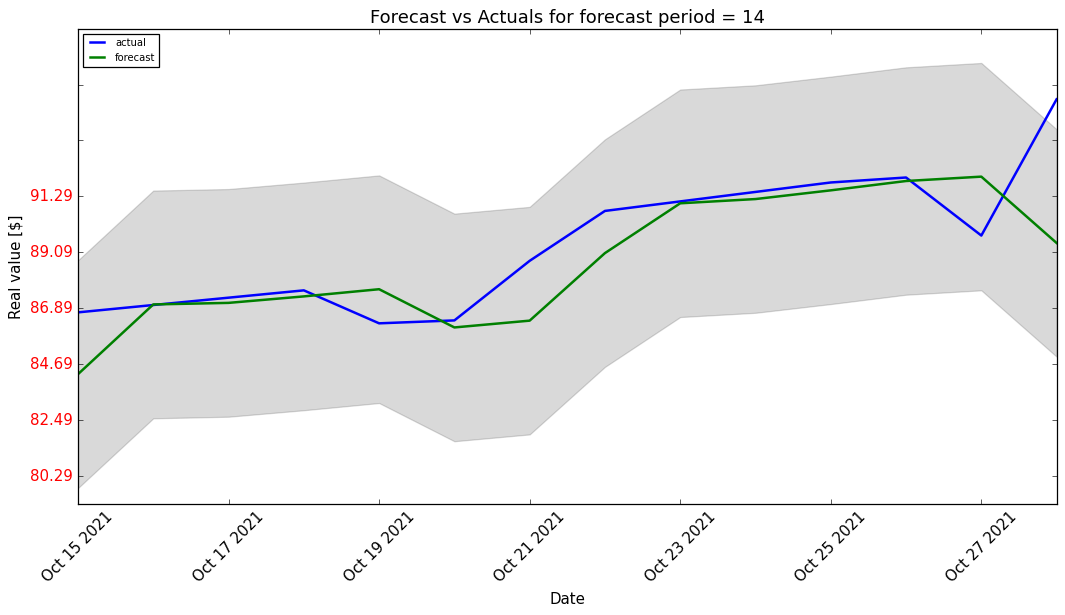

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(1,1,1)  1  1  1         7  0.008102
1     ACN  ARIMA(1,1,1)  1  1  1        14  0.006560
2     ACN  ARIMA(1,1,1)  1  1  1        28  0.007880
3    AMZN  ARIMA(1,1,1)  1  1  1         7  0.010909
4    AMZN  ARIMA(1,1,1)  1  1  1        14  0.008263
5    AMZN  ARIMA(1,1,1)  1  1  1        28  0.006738
6    ARCB  ARIMA(1,1,1)  1  1  1         7  0.013555
7    ARCB  ARIMA(1,1,1)  1  1  1        14  0.011240
Forecast results for per=0
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  4.414842  0.020814       4.374048       4.455636
predicted=4.414842, expected=4.421983
Forecast results for per=1
y      mean  mean_se  mean_ci_lower  mean_ci_upper
0  4.425436  0.02081       4.384648       4.466224
predicted=4.425436, expected=4.426968
Forecast results for per=2
y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  4.428162  0.020807       4.387382       4.468942
predicted=4.428162, expected=4.431930
Forecast results f

,prediction,se,lower_series,upper_series
0,4.414842,0.020814,4.374048,4.455636
1,4.425436,0.020810,4.384648,4.466224
2,4.428162,0.020807,4.387382,4.468942
3,4.432762,0.020803,4.391989,4.473534
4,4.437638,0.020799,4.396872,4.478403
5,4.465347,0.020800,4.424579,4.506115
6,4.478453,0.020798,4.437691,4.519216
7,4.482236,0.020794,4.441481,4.522991
8,4.473371,0.020791,4.432622,4.514120
9,4.476983,0.020787,4.436241,4.517724


2.7159613358862242

4.52473071657285

step: 0.2583956258123751


2.7159613358862242
2.974356961698599
3.232752587510974
3.491148213323349
3.749543839135724
4.007939464948099
4.2663350907604745
4.524730716572849
4.7831263423852235


[2.72, 2.97, 3.23, 3.49, 3.75, 4.01, 4.27, 4.52, 4.78]

2.7159613358862242

4.52473071657285

15.11913765743077

92.27107541149164

step: 11.021705393437268


15.11913765743077
26.140843050868035
37.1625484443053
48.18425383774257
59.20595923117983
70.22766462461709
81.24937001805436
92.27107541149164


[15.12, 26.14, 37.16, 48.18, 59.21, 70.23, 81.25, 92.27]

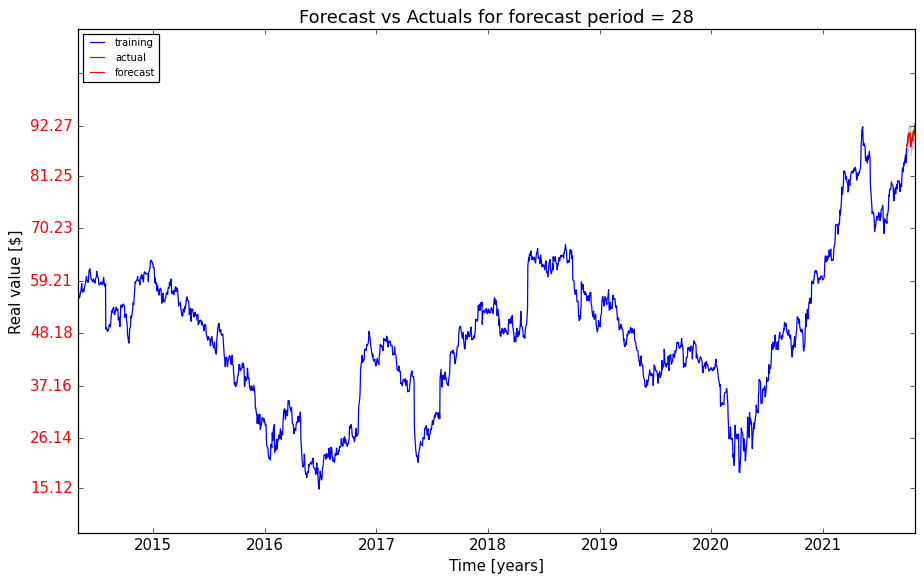

min value 4.3732199032892956 max value 4.537723871565626
min value 4.37 max value 4.54
step: 0.02




'final y list'

[4.37, 4.39, 4.41, 4.43, 4.45, 4.47, 4.49, 4.51, 4.53, 4.55]

min value 4.3732199032892956 max value 4.537723871565626
min exp value 79.3 max exp value 93.48
step: 2.36




'final y exp list'

[79.3, 81.66, 84.02, 86.38, 88.74, 91.1, 93.46]

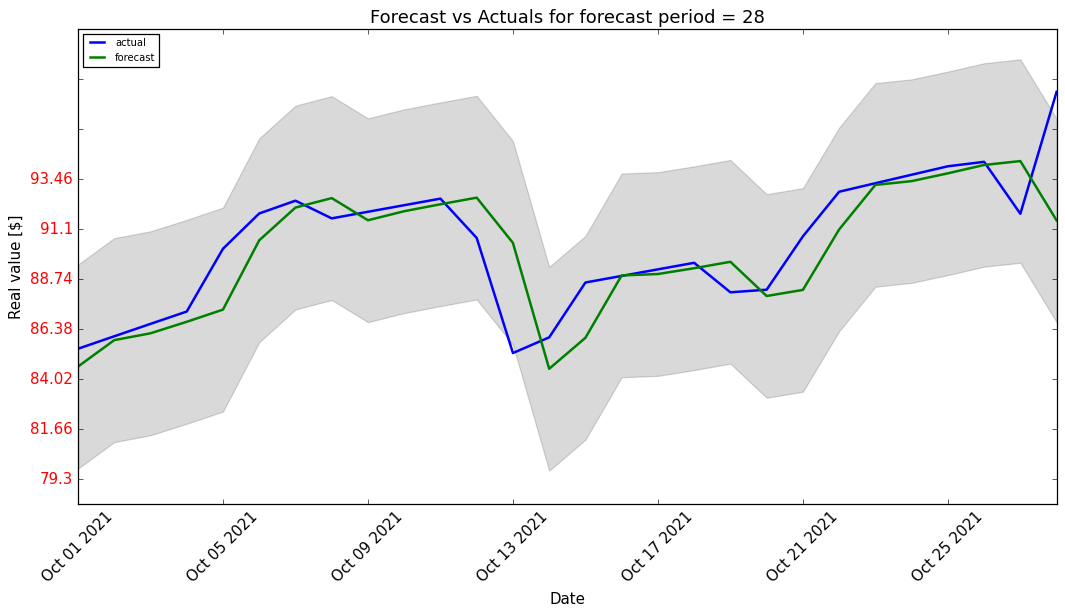

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(1,1,1)  1  1  1         7  0.008102
1     ACN  ARIMA(1,1,1)  1  1  1        14  0.006560
2     ACN  ARIMA(1,1,1)  1  1  1        28  0.007880
3    AMZN  ARIMA(1,1,1)  1  1  1         7  0.010909
4    AMZN  ARIMA(1,1,1)  1  1  1        14  0.008263
5    AMZN  ARIMA(1,1,1)  1  1  1        28  0.006738
6    ARCB  ARIMA(1,1,1)  1  1  1         7  0.013555
7    ARCB  ARIMA(1,1,1)  1  1  1        14  0.011240
8    ARCB  ARIMA(1,1,1)  1  1  1        28  0.010736
counter 3
  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(1,1,1)  1  1  1         7  0.008102
1     ACN  ARIMA(1,1,1)  1  1  1        14  0.006560
2     ACN  ARIMA(1,1,1)  1  1  1        28  0.007880
3    AMZN  ARIMA(1,1,1)  1  1  1         7  0.010909
4    AMZN  ARIMA(1,1,1)  1  1  1        14  0.008263
5    AMZN  ARIMA(1,1,1)  1  1  1        28  0.006738
6    ARCB  ARIMA(1,1,1)  1  1  1         7  0.013555
7    ARCB  ARIMA(1,1,1)  1  1  1    

In [16]:
mae_df = pd.DataFrame(columns = COLUMN_NAMES)
tmp_counter = 0
for path in PREPROCESSED_DATA_PATHS: 
    #SET PLOTS STYLE
    plt.style.use('fivethirtyeight')
    plt.style.use('seaborn-bright')
    #extract company name for further plots
    splitted = path.split("\\")[-1]
    company = splitted.split(".csv")[0]
    print(company)
    df = pd.read_csv(path, index_col=0)
    df.timestamp = pd.to_datetime(df.timestamp)
    df.sort_values(by='timestamp', inplace=True)
    display(df)
    
    #1. Time Series decomposition
    decompose_time_series(df.copy(), company, PERIOD)
    
    #2. Logarithm of company
    if USE_LOG:
        df.avg_price = np.log(df.avg_price)    
    visualize_after_log(df)
    display(df)
        
    #3. Stationarity
    test_statistic, critical_value = perform_df_test(df.avg_price, REGRESSION_TYPE_FOR_DF_TEST, AUTOLAG_FOR_DF_TEST, P_VALUE_PERCENT)
    print(test_statistic, critical_value)
    number_of_first_diff = 0
    if test_statistic > critical_value:
        while(test_statistic > critical_value):
            number_of_first_diff += 1
            df_diff = perform_first_difference(df.copy(), number_of_first_diff)
            test_statistic, critical_value = perform_df_test(df_diff.diff_price, REGRESSION_TYPE_FOR_DF_TEST, AUTOLAG_FOR_DF_TEST, P_VALUE_PERCENT)
            print(f"Number of first diff = {number_of_first_diff}")
            print(test_statistic, critical_value)
            if number_of_first_diff > 2:
                print(f"WARNING! SOMETHING IS WRONG - THERE WAS {number_of_first_diff} first difference")
    else:
        #if no first diff performed - we still need df_diff for further computations
        df_diff = df.copy()
        df_diff = df_diff.rename(columns={'avg_price': 'diff_price'})
    print(f"Number of performed first diff = {number_of_first_diff}")
    display('Original dataframe', df)
    display('First differenced dataframe', df_diff)
    
    #EXTRA STEP: SAVE ACF and PACF chart
    """
    They are used to choose p, q paramaters: usually we count up to 10th tab, how many of them is above the significance level. 
    They are also used to check stationarity: if the tabs come down quickly, then this suggests that the series should be stationary.
    """
    create_acf_pacf_charts(df_diff.diff_price, LJUNGBOX_BOXPIERCE_LAGS, 'timeseries')
    
    #4. Automatically choose ARIMA parameters p, d, q
    """
    IMPORTANT!! I PERFORM ARIMA ON DIFFERENCED AND LOGGED VALUES!!
    Only log values was not enough (not stationary).
    """
    d = number_of_first_diff
    p_range = P_RANGE #range(0, 10)
    q_range = Q_RANGE #range(0, 10)
    #POSSIBLE ARIMA COMBINATIONS - ANALIZA AUTOMATYCZNA
    arima_combinations_list = []
    aic_results_list = []
    bic_results_list = []
    p_parameter_list = []
    d_parameter_list = []
    q_parameter_list = []
    #hqic_results_list = []
    for p in p_range:
        for q in q_range:
            results = ARIMA(df_diff.diff_price, order=(p, d, q), enforce_stationarity=False).fit() #method='innovations_mle'; disp=-1
            #df_diff.diff_price, initialization='approximate_diffuse'
            #, enforce_stationarity=False should help
            #https://github.com/statsmodels/statsmodels/issues/5459
            arima_combinations_list.append(f"ARIMA({p},{d},{q})")
            p_parameter_list.append(p)
            d_parameter_list.append(d)
            q_parameter_list.append(q)
            aic_results_list.append(results.aic)
            bic_results_list.append(results.bic)
            #hqic_results_list.append(results.hqic)            
    print(aic_results_list)
    print(bic_results_list)
    #print(hqic_results_list)
    auto_ARIMA_df = pd.DataFrame(list(zip(arima_combinations_list, 
                                          p_parameter_list, 
                                          d_parameter_list,
                                          q_parameter_list,
                                          aic_results_list, 
                                          bic_results_list)), 
                             columns=['ARIMA', 'p', 'd', 'q', 'AIC', 'BIC'])
    display(auto_ARIMA_df)
    #Save model results to CSV
    auto_ARIMA_df.to_csv(ARIMA_MODEL_RESULTS + '/{0}_ARIMA_parameters.csv'.format(company))
    
    print('Best ARIMA according to AIC criterium:')
    best_ARIMA_aic = auto_ARIMA_df.sort_values(by=['AIC']).iloc[0]
    print(best_ARIMA_aic)
    p_best_aic = best_ARIMA_aic[1]
    q_best_aic = best_ARIMA_aic[3]
    
    print('\nBest ARIMA according to BIC criterium:')
    best_ARIMA_bic = auto_ARIMA_df.sort_values(by=['BIC']).iloc[0]
    print(best_ARIMA_bic)
    p_best_bic = best_ARIMA_bic[1]
    q_best_bic = best_ARIMA_bic[3]
    
    best_pq_list = []
    best_pq_list.append((p_best_aic, q_best_aic))
    if ((p_best_aic, q_best_aic) != (p_best_bic, q_best_bic)):
        best_pq_list.append((p_best_bic, q_best_bic))

    #5. Check the autocorrelations for residuals (white noise)
    for pq in best_pq_list:
        lb_p_value, bp_p_value, residuals = perform_ljungbox_boxpierce(df.avg_price, int(pq[0]), d, int(pq[1]), LJUNGBOX_BOXPIERCE_LAGS)
        create_acf_pacf_charts(residuals, LJUNGBOX_BOXPIERCE_LAGS, 'residuals')
        if (P_VALUE > lb_p_value) or (P_VALUE > bp_p_value):
            img = mpimg.imread(ARIMA_PLOTS + '/{0}_{1}_plot_ACF_and_PACF.png'.format(company, 'residuals'), format='png')
            # Output Images
            fig = plt.figure(figsize=(18,12), dpi=140)
            plt.axis('off') #turn off axis
            plt.title(f'Please decide, if the residuals are white noise.\n \
                When you are ready, close the window and choose. \n \
                Llungbox p_value = {round(lb_p_value, 4)}, Boxpierce p_value = {round(bp_p_value, 4)}. \n \
                Chosen p_value level is {P_VALUE}')
            plt.imshow(img)
            plt.show()
            #USER HAS TO CHOOSE, IF THE SERIES IS STATIONARY
            #TODO: implement tkinter, when this will be a python script
            answer = input('Do the residuals approximate white noise? [y/n]: ') 
            if answer == 'n':
                print('IT IS NOT POSSIBLE TO PERFORM THE FORECAST!\n')
                print('THE MODEL IS ABANDONED!\n')
                #TODO: implement some info ebout this to log file
                continue #this will end this for loop iteration
        #The residuals of the model are white noise. We can proceed.

        #6. PERFORM ARIMA FORECAST
        for period in PERIODS_TO_FORECAST:
            #Prepare train and test set
            #df.index = df.timestamp
            #Używamy wartości tylko po logarytmie, żeby inwestor miał prawdziwe wartości (exp(log_value))
            train = df.avg_price[:-period]
            test = df.avg_price[-period:]
            test_timestamp = df.timestamp[-period:]
            train_timestamp = df.timestamp[:-period]

            #define lists to be predicted
            history = [x for x in train]
            future = [x for x in test]
            predictions = []
            se_list = []
            lower_series_list = []
            upper_series_list = []
            #Train the model separately for every prediction
            #https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
            for per in range(period):
                model = ARIMA(history, order=(pq[0], d, pq[1])) 
                fitted = model.fit()
                fcast_res = fitted.get_forecast(steps=1, alpha=P_VALUE)
                print("Forecast results for per={0}".format(per))
                print(fcast_res.summary_frame())
                fc = fcast_res.summary_frame()['mean'][0]
                predictions.append(fc)
                se = fcast_res.summary_frame()['mean_se'][0]
                se_list.append(se)
                lower_series = fcast_res.summary_frame()['mean_ci_lower'][0]
                lower_series_list.append(lower_series)
                upper_series = fcast_res.summary_frame()['mean_ci_upper'][0]
                upper_series_list.append(upper_series) 
                #append to the test set
                obs = future[per]
                history.append(obs)
                print('predicted=%f, expected=%f' % (fcast_res.summary_frame()['mean'], obs))
            #print predictions
            prediction_df = pd.DataFrame(
                {'prediction': predictions,
                 'se': se_list,
                 'lower_series': lower_series_list,
                 'upper_series': upper_series_list
                })
            display(prediction_df)
            #print model summary
            #print(fitted.summary())
            #save summary to file
            #_path = ARIMA_MODEL_RESULTS + f'/{company}_ARIMA({pq[0]},{d},{pq[1]})_model_summary_period_{period}.csv'
            #with open(_path, 'w') as f:
            #    f.write(fitted.summary().as_csv())

            #Test the model (perform forecast)
            #https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html
            #fcast_res = fitted.get_forecast(steps=period, alpha=P_VALUE)  # 3 okresy do przodu, 95% conf
            #fc = fcast_res.summary_frame()['mean']
            #se = fcast_res.summary_frame()['mean_se']
            #lower_series = fcast_res.summary_frame()['mean_ci_lower']
            #upper_series = fcast_res.summary_frame()['mean_ci_upper']
            #get_forecast instead of forecast
            #se - błąd standardowy, standard error
            #fc - forecast
            #conf - poziom ufności, confidence interval
            # Make as pandas series - NOT NEEDED ANY MORE
            #fc_series = pd.Series(fc, index=test.index)
            #lower_series = pd.Series(conf[:, 0], index=test.index)
            #upper_series = pd.Series(conf[:, 1], index=test.index)           

            #Make plots
            create_prediction_plot(df, train, test, predictions, lower_series_list, upper_series_list, period, train_timestamp, test_timestamp)
            create_zoomed_prediction_plot(df, test, predictions, lower_series_list, upper_series_list, period, test_timestamp)
            #Calculate MAE
            mae = np.mean(np.abs(predictions - test.values))

            #7. SAVE RESULTS
            #7.1 results of specific experiment
            forecast_results = pd.DataFrame(zip(test.values, predictions), columns=['True_Value', 'ARIMA_forecast'])
            forecast_results['Company'] = 'ACN'
            forecast_results.to_csv(ARIMA_MODEL_RESULTS + f'/{company}_forecast_results_ARIMA({pq[0]},{d},{pq[1]})_period_{period}.csv')
            #7.2 MASTER TABLE
            #[company, ARIMA, p,d,q , period, mae]
            arima_tmp = f'ARIMA({pq[0]},{d},{pq[1]})'
            mae_list = [company, arima_tmp, pq[0], d, pq[1], period, mae] 
            mae_df = mae_df.append(pd.Series(mae_list, index = mae_df.columns), ignore_index=True)
            print(mae_df)
        
    tmp_counter += 1
    print("counter", tmp_counter)
    if tmp_counter == 3:
        break
#7.3 After all experiments
saving_time = datetime.now().strftime('%Y-%m-%d_%H_%M')
mae_df.to_csv(ARIMA_MODEL_RESULTS + f'/MASTER_TABLE_forecast_results_{saving_time}.csv')
print(mae_df)

In [15]:
test

2695    4.421983
2696    4.426968
2697    4.431930
2698    4.436866
2699    4.461972
2700    4.476083
2701    4.481193
2702    4.474122
2703    4.476761
2704    4.479392
2705    4.482016
2706    4.466292
2707    4.420277
2708    4.426533
2709    4.448477
2710    4.451109
2711    4.453734
2712    4.456353
2713    4.444556
2714    4.445599
2715    4.466920
2716    4.484775
2717    4.488180
2718    4.491574
2719    4.494956
2720    4.496736
2721    4.475970
2722    4.524731
Name: avg_price, dtype: float64

In [14]:
fcast_res.summary_frame()

avg_price,mean,mean_se,mean_ci_lower,mean_ci_upper
2716,4.469681,0.020772,4.428969,4.510393
2717,4.470446,0.031345,4.409012,4.531881
2718,4.470659,0.039614,4.393017,4.548300
2719,4.470717,0.046541,4.379498,4.561936
2720,4.470734,0.052590,4.367659,4.573809
2721,4.470738,0.058019,4.357023,4.584453
2722,4.470739,0.062983,4.347295,4.594183


In [43]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              avg_price   No. Observations:                 2693
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6609.328
Date:                Fri, 05 Nov 2021   AIC                         -13212.656
Time:                        00:07:02   BIC                         -13194.962
Sample:                             0   HQIC                        -13206.256
                               - 2693                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2985      0.132      2.258      0.024       0.039       0.558
ma.L1         -0.1687      0.137     -1.235      0.217      -0.437       0.099
sigma2         0.0004   3.51e-06    122.850      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       38.46   Jarque-Bera (JB):             51713.46
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [3]:
from scipy import linalg
print(linalg.lapack.dgetrf([np.nan]))
print(linalg.lapack.dgetrf([np.inf]))

(array([nan]), array([0], dtype=int32), 0)
(array([inf]), array([0], dtype=int32), 0)


# SANDBOX ***

In [27]:
for per in range(period):
    print(per)

0
1
2
3
4
5
6


In [24]:
range(len(test))

range(0, 7)

In [22]:
[x for x in test]

[4.48477491586037,
 4.488180040089363,
 4.491573608784243,
 4.494955700108903,
 4.496735828010994,
 4.475969665628219,
 4.52473071657285]

In [16]:
[x for x in train]

[3.664621851226728,
 3.655173718250689,
 3.6614848323621385,
 3.6677563659787293,
 3.673988812470318,
 3.669614070469464,
 3.668979352052798,
 3.6885696104573076,
 3.685461251757141,
 3.696798495070624,
 3.708008644842521,
 3.7190945190175495,
 3.7361584381961017,
 3.7241438122497836,
 3.6935263341191282,
 3.6937024684337993,
 3.6986087083135626,
 3.7034909944784244,
 3.7083495596906797,
 3.6960818428086473,
 3.7108975506430273,
 3.7137830546342845,
 3.7200088420476463,
 3.7281018451569157,
 3.736129877027527,
 3.744093972544852,
 3.751995142063462,
 3.769714667158124,
 3.7716336379794537,
 3.7551136656364936,
 3.7508209366630956,
 3.746509700693598,
 3.7421797974604982,
 3.7446707239701293,
 3.7440181323857984,
 3.768881887478071,
 3.7986868736268997,
 3.8023136245220677,
 3.8059272696123565,
 3.809527903276375,
 3.7909518878998165,
 3.7776037597762104,
 3.770403531810988,
 3.7577399525787922,
 3.755807196479269,
 3.7538706975985554,
 3.7519304414127337,
 3.7485097209148277,
 3.750448

In [15]:
train

0       3.664622
1       3.655174
2       3.661485
3       3.667756
4       3.673989
          ...   
2711    4.453734
2712    4.456353
2713    4.444556
2714    4.445599
2715    4.466920
Name: avg_price, Length: 2716, dtype: float64

In [29]:
print("Forecast results for per={0}".format(per))
print(fcast_res.summary_frame())

Forecast results for per=6
avg_price      mean   mean_se  mean_ci_lower  mean_ci_upper
2716       4.469681  0.020772       4.428969       4.510393
2717       4.470446  0.031345       4.409012       4.531881
2718       4.470659  0.039614       4.393017       4.548300
2719       4.470717  0.046541       4.379498       4.561936
2720       4.470734  0.052590       4.367659       4.573809
2721       4.470738  0.058019       4.357023       4.584453
2722       4.470739  0.062983       4.347295       4.594183


In [44]:
fcast_res.summary_frame()['mean'][0]

5.838152189814214

In [48]:
predictions

[5.794014865330889,
 5.796983133512704,
 5.82368650157518,
 5.833290201010528,
 5.834350151028071,
 5.836168118887822,
 5.838152189814214]

In [47]:
prediction_df

,prediction,se,lower_series,upper_series
0,5.794015,0.011114,5.772232,5.815797
1,5.796983,0.011113,5.775203,5.818764
2,5.823687,0.011117,5.801898,5.845475
3,5.833290,0.011116,5.811502,5.855078
4,5.834350,0.011115,5.812565,5.856136
5,5.836168,0.011114,5.814385,5.857952
6,5.838152,0.011113,5.816371,5.859934


In [49]:
fc

5.838152189814214

### TK inter

In [ ]:
def ExitApplication():
    MsgBox = tk.messagebox.askquestion('Exit Application', 'Are you sure you want to exit the application', icon = 'warning')
    if MsgBox == 'yes':
        root.destroy()
    else:
        tk.messagebox.showinfo('Return','You will now return to the application screen')

In [ ]:
#from tkinter import * as tk
import tkinter as tk
root = tk.Tk()

In [ ]:
import tkinter as tk
from tkinter import messagebox
import tkinter as tk
root = tk.Tk()

canvas1 = tk.Canvas(root, width = 300, height = 300)
canvas1.pack()

button1 = tk.Button(root, text='Exit Application', command=ExitApplication, bg='brown', fg='white') 
canvas1.create_window(150, 150, window=button1)